In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import itertools 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from google.cloud import bigquery
from google.oauth2 import service_account
from datetime import datetime
from dateutil.relativedelta import relativedelta
from functions import *
from constants import *


x13_path = r"C:\Users\adojeda\Downloads\x13as\x13as_ascii"

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#

pd.set_option('display.max_columns', None)

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#

def scaled_pca(X, n = 3):
    scaler = StandardScaler().set_output(transform="pandas")
    scaled_X = scaler.fit_transform(X)
    X_scaled_pca = PCA(n_components=n).fit_transform(scaled_X)
    X_scaled_pca = pd.DataFrame(X_scaled_pca, columns= ["pca_" + str(i+1) for i in range(n)], index = X.index)
    return X_scaled_pca

path = "..\\..\\bd\\EXOGENAS_MIDAS"

os.listdir(path)

config_file = {
    "ENEC_Jul25.xlsx": {"header":0, "index_col": 0, "usecols": "A,AE:BB" , "sheet_name" :"Serie (nominal y real)"},
    "IGAE_jul25.xlsx": {"header":0, "index_col" :"Periodos",  "usecols": None,  "sheet_name": "Series"},
    "inputs_INFLACION.xlsx": {"header":0, "index_col" :"Periodos",  "usecols": None, "sheet_name": "Serie"},
    "Mercados Verticales julio25.xlsx": {"header":0, "index_col" :"Periodos",  "usecols": None, "sheet_name": "Series"},
    #"inputs_TIPO_OBRAXESTADO.xlsx": {"header":[0,1], "index_col" : 0,  "usecols": None}, # ("Tipo de Obra", "Periodos")},    
    "inputs_TIPO_OBRA_ESTADO.xlsx": {"header":[0,1], "index_col" : 0,  "usecols": None, "sheet_name": "Original"}# ("Tipo de Obra", "Periodos")},
    }

exog = []
for file_ in os.listdir(path): 

    print(file_)
    path_file = path + "\\" + file_
    df = pd.read_excel(path_file, header =  config_file[file_]["header"], index_col= config_file[file_]["index_col"] , usecols=  config_file[file_]["usecols"], sheet_name=config_file[file_]["sheet_name"] )
    df.index = df.index.astype(str).str[:7]
    df.index = pd.to_datetime(df.index.str[:7], format = "%Y/%m", errors="coerce")
    if "TIPO_OBRA" in file_:
        df.columns = df.columns.to_flat_index()
        df.index.name = "Periodos"
    
    exog.append(df)

df_exog = exog[0] 
for right in exog[1:]:
    df_exog = df_exog.merge(right, left_index=True, right_index=True, how='left', validate= "1:1")
df_exog.index.name = "MesAnio"

df_exog = df_exog.loc[df_exog.index >="2020-01-01"]
df_exog = df_exog.loc[df_exog.index <"2026-01-01"]
df_exog = df_exog.loc[:, df_exog.isna().sum() ==  0]

pca_exog = scaled_pca(df_exog, n = 3)
pca_exog.head()

ENEC_Jul25.xlsx
IGAE_jul25.xlsx
inputs_INFLACION.xlsx
inputs_TIPO_OBRA_ESTADO.xlsx
Mercados Verticales julio25.xlsx


,pca_1,pca_2,pca_3
MesAnio,,,
2020-01-01,-2.870007,-0.324748,4.254435
2020-02-01,-4.001541,-1.864636,4.554710
2020-03-01,-3.700909,-0.957328,3.315538
2020-04-01,-15.369159,-3.408590,5.519157
2020-05-01,-15.577296,-3.492950,4.391954


df_exog

In [37]:
import pandas as pd
import numpy as np
import calendar
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, MO

# Crear rango de fechas mensual hasta 2027
fechas = pd.date_range(start='2018-01-01', end='2027-12-31', freq='MS')

# Definir días festivos oficiales en México
class MexicoHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('Año Nuevo', month=1, day=1, observance=nearest_workday),
        Holiday('Día de la Constitución', month=2, day=5, observance=lambda dt: dt + pd.DateOffset(weekday=MO(1))),
        Holiday('Natalicio de Benito Juárez', month=3, day=21, observance=lambda dt: dt + pd.DateOffset(weekday=MO(3))),
        Holiday('Día del Trabajo', month=5, day=1),
        Holiday('Día de la Independencia', month=9, day=16),
        Holiday('Día de la Revolución', month=11, day=20, observance=lambda dt: dt + pd.DateOffset(weekday=MO(3))),
        Holiday('Navidad', month=12, day=25, observance=nearest_workday),
    ]

# Instanciar calendario de días festivos
calendario = MexicoHolidays()
dias_festivos = calendario.holidays(start='2018-01-01', end='2027-12-31')

# Crear DataFrame de regresores
regresores = pd.DataFrame({'fecha': fechas})
regresores['dias_laborables'] = regresores['fecha'].apply(lambda x: np.busday_count(x.date(), (x + pd.offsets.MonthEnd(0)).date()))
#regresores['dias_festivos'] = regresores['fecha'].apply(lambda x: sum((dias_festivos >= x) & (dias_festivos <= x + pd.offsets.MonthEnd(0))))
regresores['diciembre_dummy'] = regresores['fecha'].dt.month.apply(lambda m: 1 if m == 12 else 0)
regresores['mes'] = regresores['fecha'].dt.month
regresores['trimestre'] = regresores['fecha'].dt.quarter
regresores['semana_santa_dummy'] = regresores['mes'].apply(lambda m: 1 if m in [3, 4] else 0)
# Variable de cambio de sexenio presidencial cada 6 años desde diciembre 2018
regresores['cambio_sexenio_dummy'] = regresores['fecha'].apply(
    lambda x: 1 if x >= pd.Timestamp('2018-12-01') and ((x.year - 2018) % 6 == 0 and x.month == 12) else 0
)

regresores['temperatura_promedio'] = regresores['mes'].apply(lambda m: 15 + 10 * np.sin((m - 1) * np.pi / 6))

# Establecer índice de fecha
regresores.set_index('fecha', inplace=True)
regresores = regresores.iloc[(regresores.index >= "2020-01-01") & (regresores.index <= "2026-08-01") ,:-1]
regresores = regresores.drop(columns="trimestre")

# Mostrar las primeras filas
regresores.head()

from statsmodels.stats.outliers_influence import variance_inflation_factor


# Calcular VIF para cada regresor
X = regresores.copy()
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Mostrar resultados
vif_data


,Variable,VIF
0,dias_laborables,6.708947
1,diciembre_dummy,1.587877
2,mes,6.684427
3,semana_santa_dummy,1.430939
4,cambio_sexenio_dummy,1.200121


In [38]:
import pandas as pd
import statsmodels.api as sm

def x_13(series, freq='M', alerts = False):
    """
    Aplica descomposición X-13ARIMA-SEATS a una serie temporal
    
    Parameters:
    -----------
    series : pd.Series
        Serie temporal con índice datetime
    freq : str
        Frecuencia de la serie ('M' para mensual, 'Q' para trimestral)
    
    Returns:
    --------
    res : X13ArimaAnalysisResult
        Objeto con los resultados de la descomposición
    """
    x13_path = r"C:\Users\adojeda\Downloads\x13as\x13as_ascii"
    
    # Asegurar que la serie tiene un índice datetime apropiado
    if not isinstance(series.index, pd.DatetimeIndex):
        raise ValueError("La serie debe tener un índice DatetimeIndex")
    
    try:
        # Ejecutar descomposición con X-13ARIMA-SEATS
        res = sm.tsa.x13_arima_analysis(
            series,
            x12path=x13_path,
            prefer_x13=True,
            #speconly = True,
            #exog= regresores.iloc[:, :-1],
            freq=freq
        )
        if alerts == True: 
        # Mostrar componentes principales
            print("\n=== Resultados X-13ARIMA-SEATS ===")
            print(f"\nSerie original: {series.name}")
            print(f"Período: {series.index[0]} a {series.index[-1]}")
            print(f"\nComponentes disponibles:")
            print(f"- Serie ajustada estacionalmente: res.seasadj")
            print(f"- Tendencia: res.trend")
            print(f"- Componente estacional: res.seasadj - res.trend")
        return res
        
    except Exception as e:
        print(series.name, "--------------------")
        print("\t\t")
        print(f"Error al ejecutar X-13: {e}")
        
        #print("\nVerifica que:")
        #print("1. El path a x13as.exe sea correcto")
        #print("2. La serie tenga al menos 3 años de datos")
        #print("3. No haya valores faltantes excesivos")
        class Serie:
            def __init__(self, series: pd.Series):
                self.values = series.values
                self.index = series.index
                self.name = series.name
                self.trend = series
        seriee = Serie(series)
        return seriee 

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

""" 
Case 1: Both tests conclude that the series is not stationary - The series is not stationary
Case 2: Both tests conclude that the series is stationary - The series is stationary
Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.
"""

def adf_test(timeseries):
    """
    H0: Existe raíz unitaria (NO estacionaria)
    H1: Es estacionaria
    Rechazar H0 si p-value < 0.05
    """
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

    if dfoutput["p-value"] < 0.05:
        print("Rechazar H0 si p-value < 0.05, H1: Es estacionaria")
    else :
        print("H0: Existe raíz unitaria (NO estacionaria)")

def kpss_test(timeseries):
    """
    H0: Es estacionaria
    H1: NO es estacionaria
    Rechazar H0 si p-value < 0.05
    """
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto") # “c” : The data is stationary around a constant (default). , “ct” : The data is stationary around a trend.
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

    if kpss_output["p-value"] < 0.05:
        print("Rechazar H0 si p-value < 0.05, H1: NO es estacionaria")
    else :
        print("H0: Es estacionaria")

Lectura de Archivos de Facturación

In [39]:
if False:
    FACT = load_fact_pvo_pv()
    FACT = add_zeros(FACT, pd.to_datetime("2024-08-01"), min_year = 2018)
    FACT.sample(5)
    FACT.to_excel(r"outputs\fact_hist.xlsx", index = False)

# ------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------

FACT = pd.read_excel(r"outputs\fact_hist.xlsx")
FACT.drop(columns= ["Unnamed: 0"], inplace= True)

ids = FACT.groupby("id").toneladas_facturadas.sum().sort_values()
ids = ids[ids > 0.01 ]

FACT

,MesAnio,id,NombreGrupo,NombreDireccion,NombreSubdireccion,NombreGrupoEstadistico1,NombreGrupoEstadistico2,NombreGrupoEstadistico3,toneladas_pvo,toneladas_plan_ventas,toneladas_facturadas,valid_ton,TP_MESES,TP_MOVIL,id2
0,2020-01-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION
1,2020-02-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION
2,2020-03-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION
3,2020-04-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION
4,2020-05-01,ACEROS_ACEROS MEXICO_INDUSTRIAS ACERÍAS_ALAMBR...,ACEROS,ACEROS MEXICO,INDUSTRIAS ACERÍAS,ALAMBRON,ALAMBRON CONSTRUCCION,ALAMBRON CONSTRUCCION,NaN,NaN,NaN,0.00000,NaN,NaN,INDUSTRIAS ACERÍAS_ALAMBRON CONSTRUCCION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169233,2025-10-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,NaN,NaN,0.0,0.00000,140.527333,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO
169234,2025-11-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,NaN,NaN,0.0,0.00000,6.804000,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO
169235,2025-12-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,NaN,NaN,0.0,0.00000,0.000000,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO
169236,2026-01-01,USA_EUA - CANADA_KEY STEEL ACCOUNTS_VARILLA_VA...,USA,EUA - CANADA,KEY STEEL ACCOUNTS,VARILLA,VARILLA,VARILLA RESTO,0.00000,0.0,0.0,0.00000,27.168373,0.0,KEY STEEL ACCOUNTS_VARILLA RESTO


# Modelación de Varilla x Grupo  (Volumen de Saturación)

**El volumen de varilla ya está validado** Saturación Semanal W40

In [40]:
map_bu = {
    "ACEROS MEXICO" : "ACEROS MEXICO" , 
    "EXPORTACION ACEROS" : "EXPORTACION ACEROS",
    "ALAMBRES": "ALAMBRES MÉXICO",
    "ALMACEN ANSA" : "ALAMBRES MÉXICO",
    "EXPORTACIÓN ALAMBRES" :"EXPORTACIÓN ALAMBRES" ,
    "INDASA": "FILIALES ALAMBRES",
    "TURIA" : "FILIALES ALAMBRES",  
    "EUA - CANADA" : "EUA - CANADA",
    "FILIALES" :  "DEACERO SOLUTIONS SUM"
    }

map_bu_pais = {
    "ACEROS MEXICO" : "Nacional" , 
    "EXPORTACION ACEROS" : "Internacional",
    "ALAMBRES": "Nacional",
    "ALMACEN ANSA" : "Nacional",
    "EXPORTACIÓN ALAMBRES" :"Internacional" ,
    "INDASA": "PROY",
    "TURIA" : "PROY",  
    "EUA - CANADA" : "Internacional",
    "FILIALES" :  "PROY"
    }

# Calculamos etiqueta de BU Y Nacional 
FACT["BU"] = FACT["NombreDireccion"].map(map_bu).fillna("2DROP")# .fillna("TO_DROP_VARILLA") # 'EXPORTACION FILIALES'

FACT["Nacional"] = FACT["NombreDireccion"].map(map_bu_pais).fillna(FACT["NombreDireccion"])

# Calculamos volumen a distintos niveles en dic VARILLA
VARILLA ={
    "GRUPO"   : FACT[FACT.BU!= "2DROP"][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["MesAnio"]).toneladas_facturadas.sum(),
    "NACIONAL": FACT[FACT.BU!= "2DROP"][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["Nacional","MesAnio"]).toneladas_facturadas.sum().unstack(["Nacional"]),
    "BU"      : FACT[FACT.BU!= "2DROP"][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["BU","MesAnio"]).toneladas_facturadas.sum().unstack(["BU"]),
    "SUBDIR"  : FACT[FACT.BU!= "2DROP"][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["NombreSubdireccion","MesAnio"]).toneladas_facturadas.sum().unstack(["NombreSubdireccion"])
}

VARILLA_TREND ={
    "GRUPO"   : x_13(VARILLA["GRUPO"]).trend,
    "NACIONAL": pd.DataFrame({i: x_13(VARILLA["NACIONAL"][i]).trend for i in VARILLA["NACIONAL"]}),
    "BU"      : pd.DataFrame({i: x_13(VARILLA["BU"][i]).trend for i in VARILLA["BU"]}),
    "SUBDIR"  :pd.DataFrame({i:  x_13(VARILLA["SUBDIR"][i]).trend  for i in VARILLA ["SUBDIR"] })
    }

AGRICULTURAL DISTRIBUTION --------------------
		
Error al ejecutar X-13: WARNING: Automatic transformation selection cannot be done on a
          series with zero or negative values.

 ERROR: Regression matrix singular because of LS2023.Sep.
        Check regression model or change automatic outlier options
        i.e. method to addone or types to identify AO only.
CONSTRUCTION DISTRIBUTION --------------------
		
Error al ejecutar X-13: WARNING: Automatic transformation selection cannot be done on a
          series with zero or negative values.

 ERROR: Regression matrix singular because of LS2021.Nov.
        Check regression model or change automatic outlier options
        i.e. method to addone or types to identify AO only.
INDUSTRIAL WIRE --------------------
		
Error al ejecutar X-13: WARNING: Automatic transformation selection cannot be done on a
          series with zero or negative values.

          the likelihood was possible.  Check iteration output to 
          confi

# Varilla Nacional

In [41]:
pd.DataFrame(VARILLA["GRUPO"]).T

MesAnio,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01
toneladas_facturadas,87192.731103,91271.26228,86961.25743,64962.4711,37990.8866,34927.89165,51736.211999,69229.79848,72192.150821,70080.553781,84577.36145,90893.911,77490.94215,91844.115067,90480.41801,99195.430798,101326.492314,104642.029705,113940.717122,75874.58338,80885.917709,49220.04488,84431.014544,99641.240783,106120.04599,96553.0419,127276.9795,103018.60658,104128.16603,112055.21737,89328.91682,92243.8077,89387.42252,97927.49385,110441.8456,116877.64717,143753.76848,133721.53104,141341.19509,117560.604086,104343.993014,111704.44334,101165.872375,99757.67358,116978.14793,133926.19412,127118.35495,135735.46777,127002.25277,87459.43916,68742.79335,111658.30127,94984.42844,90523.00244,76485.5903,84262.13113,66995.91022,72669.414064,69757.96762,77198.57424,94126.4517,77275.18824,89211.89773,85168.881624,85785.76134,78699.86787,71112.732335,92341.419637


In [42]:
pd.DataFrame(VARILLA_TREND["GRUPO"]).T

MesAnio,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01
trend,77199.879134,72381.715428,67205.708061,62311.335108,59013.468845,58737.360838,62319.861094,68540.560862,75098.76899,79495.687049,81097.907323,81190.734741,81944.499404,84538.2382,88861.771863,93754.368061,97524.340602,98808.341613,97145.804546,93614.751247,89643.458055,87120.319153,87290.11038,89611.210488,93464.222482,98001.474108,102343.645604,105558.543637,106750.804349,106099.744882,104152.133608,102237.566637,102110.943759,104898.395699,110235.581735,116711.682197,121861.40128,124053.279613,122811.964124,118900.259336,114726.883952,112595.21717,113923.287458,118572.456173,123859.132859,126822.799814,125340.987217,119647.836923,111438.459824,102855.585555,96468.76822,93278.514387,92257.665692,91535.035262,89491.30352,85579.674263,80731.459631,76377.849459,73440.150317,72705.350756,74003.576025,76404.966947,78943.188095,81375.847733,84177.928599,87412.992211,90788.773124,93480.667457


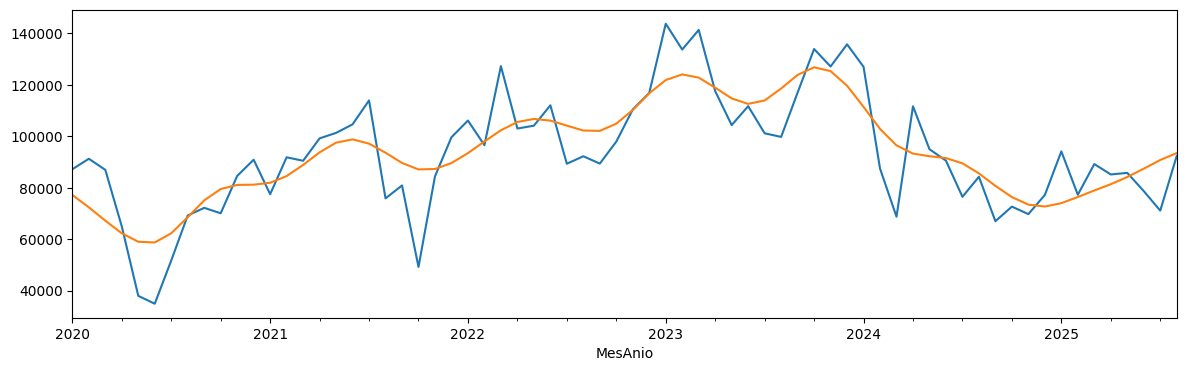

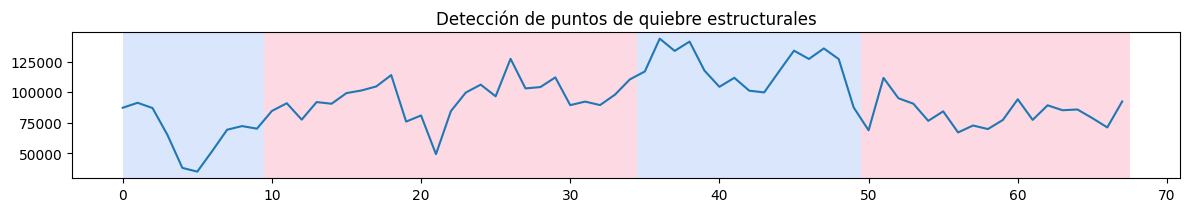

In [43]:
VARILLA["GRUPO"].round(1).plot( figsize=(14.25, 4))
VARILLA_TREND["GRUPO"].round(1).plot( figsize=(14.25, 4))

import matplotlib.pyplot as plt
import ruptures as rpt

signal = VARILLA["GRUPO"].values
model = 'normal' #"rbf"
algo = rpt.Pelt(model=model).fit(signal)
breakpoints = algo.predict(pen=10)

# Visualización
rpt.display(signal, breakpoints, figsize=(12, 2))
plt.title("Detección de puntos de quiebre estructurales")
plt.show()


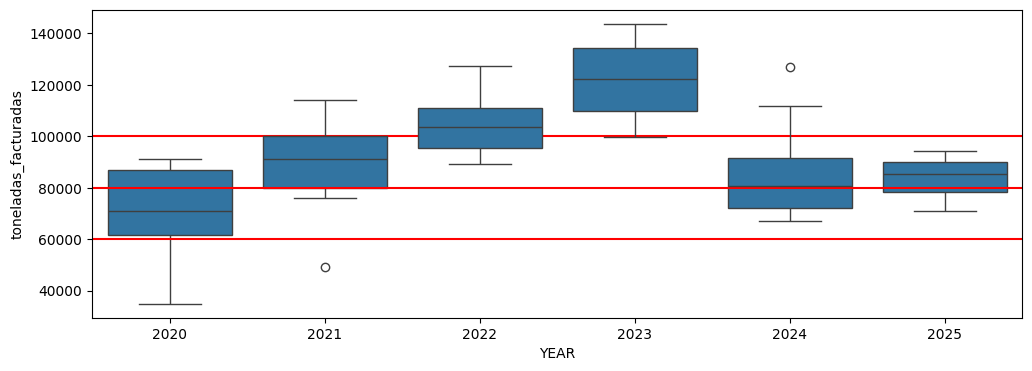

In [44]:
import seaborn as sns

box = VARILLA["GRUPO"].reset_index()
box["YEAR"] = box.MesAnio.dt.year
box["Q"] = box.MesAnio.dt.quarter
plt.figure(figsize=(12, 4))
plt.axhline(y=100000, color='r', linestyle='-')
sns.boxplot(box, x ="YEAR", y = "toneladas_facturadas")
plt.axhline(y=60000, color='r', linestyle='-')
plt.axhline(y=80000, color='r', linestyle='-')

Las series de Saturación varilla muestran cambios estructurales/ BURBUJA EN EL AÑO 2023

## Prueba de ADFULLER

H0: Existe raíz unitaria (NO estacionaria)

H1: Es estacionaria

Rechazar H0 si p-value < 0.05

In [45]:
adf_test(VARILLA["GRUPO"])
print("\t")
kpss_test(VARILLA["GRUPO"])
print("\t")
print("\t ----CALCULANDO TENDENCIA ----")
print("\t")
adf_test(VARILLA_TREND["GRUPO"])
print("\t")
kpss_test(VARILLA_TREND["GRUPO"])

Results of Dickey-Fuller Test:
Test Statistic                 -3.062430
p-value                         0.029461
#Lags Used                      0.000000
Number of Observations Used    67.000000
Critical Value (1%)            -3.531955
Critical Value (5%)            -2.905755
Critical Value (10%)           -2.590357
dtype: float64
Rechazar H0 si p-value < 0.05, H1: Es estacionaria
	
Results of KPSS Test:
Test Statistic           0.318045
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
H0: Es estacionaria
	
	 ----CALCULANDO TENDENCIA ----
	
Results of Dickey-Fuller Test:
Test Statistic                 -4.014149
p-value                         0.001338
#Lags Used                      3.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critic

ADFULLER confirma que los datos son estacionarios  P valor < $\alpha$

KPSS confirma que los datos son estacionarios Pvalor > $\alpha$ 

Los resultados se replican para la tendencia

Conclusión

Al nivel de 

=== ANÁLISIS DE TENDENCIA ===
Tendencia inicial: 77199.88
Tendencia final: 93480.67
Cambio total: 16280.79
Cambio porcentual: 21.09%
Crecimiento promedio mensual: 0.37%

=== ANÁLISIS DE ESTACIONALIDAD ===

Factores estacionales promedio por mes:
Ene: 1.1707
Feb: 1.0543
Mar: 1.1599
Abr: 1.0185
May: 0.9521
Jun: 1.0076
Jul: 0.8605
Ago: 0.8885
Sep: 0.9062
Oct: 0.9454
Nov: 0.9943
Dic: 1.0703

Mes con mayor estacionalidad: Ene
Mes con menor estacionalidad: Jul

=== PROYECCIÓN DE TENDENCIA (12 períodos) ===
Tendencia proyectada en 12 meses: 105408.29

=== SERIE AJUSTADA ===
Desviación estándar original: 22941.73
Desviación estándar ajustada: 21886.07
Reducción de variabilidad: 4.6%


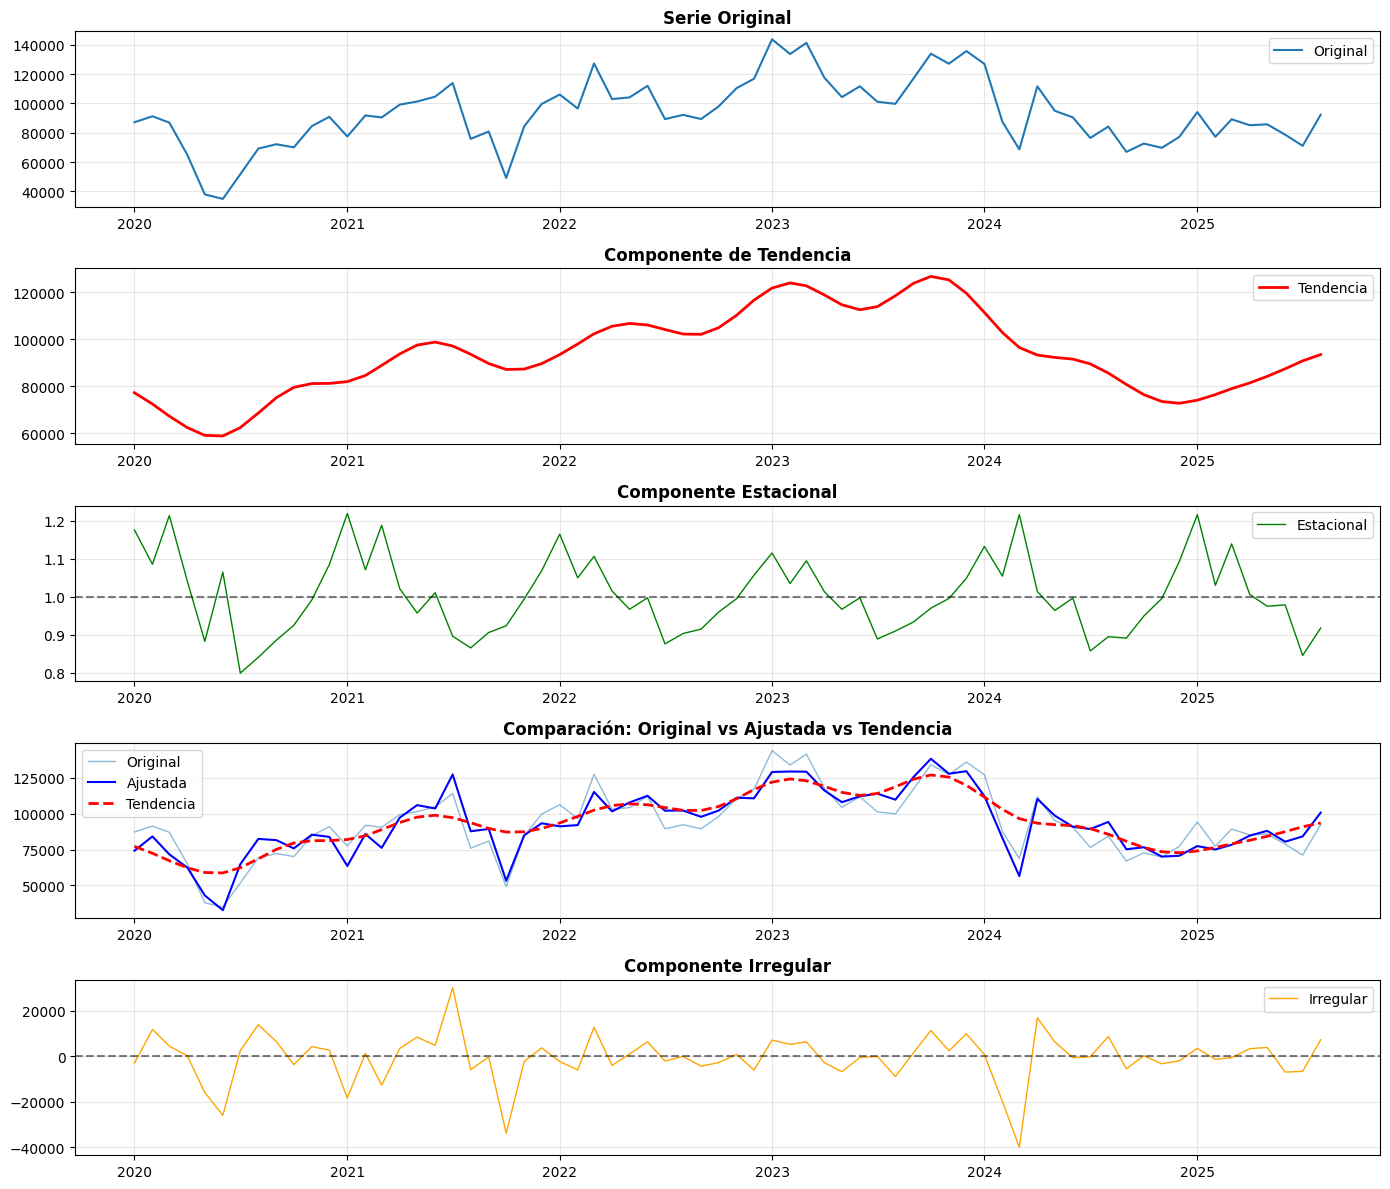

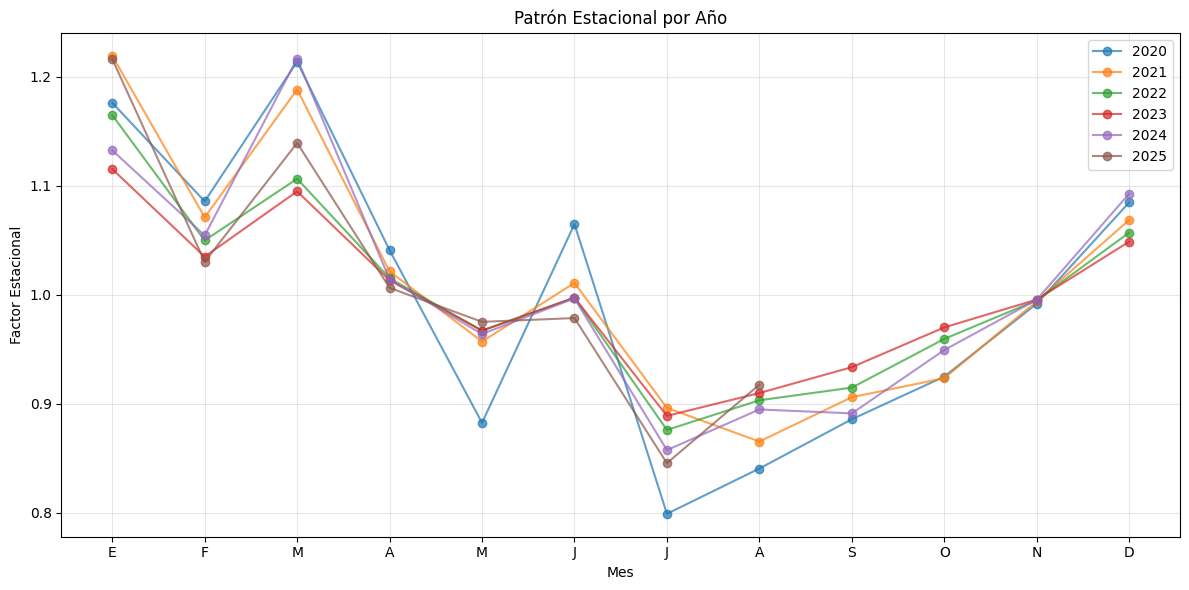


=== PRIMERAS 10 OBSERVACIONES ===
                Original     Tendencia  Estacional      Ajustada     Irregular
MesAnio                                                                       
2020-01-01  87192.731103  77199.879134    1.176104  74136.908175  -3062.970959
2020-02-01  91271.262280  72381.715428    1.085671  84068.976724  11687.261296
2020-03-01  86961.257430  67205.708061    1.213833  71641.877896   4436.169835
2020-04-01  64962.471100  62311.335108    1.040819  62414.754813    103.419705
2020-05-01  37990.886600  59013.468845    0.882477  43050.286677 -15963.182168
2020-06-01  34927.891650  58737.360838    1.064786  32802.740600 -25934.620238
2020-07-01  51736.211999  62319.861094    0.798991  64751.953623   2432.092529
2020-08-01  69229.798480  68540.560862    0.840545  82363.001645  13822.440783
2020-09-01  72192.150821  75098.768990    0.885757  81503.350305   6404.581316
2020-10-01  70080.553781  79495.687049    0.924879  75772.642676  -3723.044373

Componentes expo

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

# Después de ejecutar x_13
series = VARILLA["GRUPO"]
resultado = sm.tsa.x13_arima_analysis(
            series,
            x12path=x13_path,
            prefer_x13=True,
            #speconly = True,
            #exog= regresores.iloc[:, :-1],
            freq="M"
        )

# ===== EXTRAER COMPONENTES =====
serie_original = resultado.observed
tendencia = resultado.trend
ajustada = resultado.seasadj
irregular = resultado.irregular
# CALCULAR componente estacional
# Para descomposición MULTIPLICATIVA (default en X-13):
estacional = serie_original / ajustada

# Para descomposición ADITIVA (si especificaste mode='additive'):
# estacional = serie_original - ajustada

# ===== VERIFICAR TIPO DE DESCOMPOSICIÓN =====
# X-13 generalmente usa multiplicativa por default
# Puedes verificar multiplicando componentes:
# Serie Original = Tendencia × Estacional × Irregular (multiplicativa)
# Serie Original = Tendencia + Estacional + Irregular (aditiva)

# ===== 1. ANÁLISIS DE TENDENCIA =====
print("=== ANÁLISIS DE TENDENCIA ===")
print(f"Tendencia inicial: {tendencia.iloc[0]:.2f}")
print(f"Tendencia final: {tendencia.iloc[-1]:.2f}")
print(f"Cambio total: {tendencia.iloc[-1] - tendencia.iloc[0]:.2f}")
print(f"Cambio porcentual: {((tendencia.iloc[-1]/tendencia.iloc[0]) - 1) * 100:.2f}%")

# Calcular tasa de crecimiento promedio
crecimiento_tendencia = tendencia.pct_change().mean() * 100
print(f"Crecimiento promedio mensual: {crecimiento_tendencia:.2f}%")

# ===== 2. ANÁLISIS ESTACIONAL =====
print("\n=== ANÁLISIS DE ESTACIONALIDAD ===")

# Factores estacionales por mes (si es mensual)
if isinstance(estacional.index, pd.DatetimeIndex):
    estacionalidad_por_mes = estacional.groupby(estacional.index.month).mean()
    print("\nFactores estacionales promedio por mes:")
    meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 
             'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    for mes, valor in zip(meses, estacionalidad_por_mes):
        print(f"{mes}: {valor:.4f}")
    
    # Identificar meses altos y bajos
    mes_alto = estacionalidad_por_mes.idxmax()
    mes_bajo = estacionalidad_por_mes.idxmin()
    print(f"\nMes con mayor estacionalidad: {meses[mes_alto-1]}")
    print(f"Mes con menor estacionalidad: {meses[mes_bajo-1]}")

# ===== 3. USAR PARA PRONÓSTICOS =====
# Proyectar tendencia (ejemplo simple con regresión lineal)
from sklearn.linear_model import LinearRegression

X = np.arange(len(tendencia)).reshape(-1, 1)
y = tendencia.values

modelo = LinearRegression()
modelo.fit(X, y)

# Proyectar 12 períodos adelante
periodos_futuros = 12
X_futuro = np.arange(len(tendencia), len(tendencia) + periodos_futuros).reshape(-1, 1)
tendencia_proyectada = modelo.predict(X_futuro)

print(f"\n=== PROYECCIÓN DE TENDENCIA ({periodos_futuros} períodos) ===")
print(f"Tendencia proyectada en {periodos_futuros} meses: {tendencia_proyectada[-1]:.2f}")

# ===== 4. RECONSTRUIR SERIE CON COMPONENTES =====
# X-13 usa descomposición multiplicativa: Original = Tendencia × Estacional × Irregular
# O aditiva: Original = Tendencia + Estacional + Irregular

# Verificar tipo de descomposición
serie_reconstruida = tendencia * estacional * irregular  # Multiplicativa
# O serie_reconstruida = tendencia + estacional + irregular  # Aditiva

# ===== 5. ELIMINAR ESTACIONALIDAD MANUALMENTE =====
# Serie sin estacionalidad (ajustada)
serie_sin_estacional = serie_original / estacional  # Multiplicativa
# O serie_sin_estacional = serie_original - estacional  # Aditiva

print(f"\n=== SERIE AJUSTADA ===")
print(f"Desviación estándar original: {serie_original.std():.2f}")
print(f"Desviación estándar ajustada: {ajustada.std():.2f}")
print(f"Reducción de variabilidad: {(1 - ajustada.std()/serie_original.std())*100:.1f}%")

# ===== 6. VISUALIZACIÓN COMPLETA =====
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Serie original
axes[0].plot(serie_original, label='Original', linewidth=1.5)
axes[0].set_title('Serie Original', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tendencia
axes[1].plot(tendencia, label='Tendencia', color='red', linewidth=2)
axes[1].set_title('Componente de Tendencia', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Estacional
axes[2].plot(estacional, label='Estacional', color='green', linewidth=1)
axes[2].axhline(y=1, color='black', linestyle='--', alpha=0.5)  # Para multiplicativa
axes[2].set_title('Componente Estacional', fontsize=12, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Serie ajustada vs tendencia
axes[3].plot(serie_original, label='Original', alpha=0.5, linewidth=1)
axes[3].plot(ajustada, label='Ajustada', color='blue', linewidth=1.5)
axes[3].plot(tendencia, label='Tendencia', color='red', linewidth=2, linestyle='--')
axes[3].set_title('Comparación: Original vs Ajustada vs Tendencia', fontsize=12, fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

# Irregular
axes[4].plot(irregular, label='Irregular', color='orange', linewidth=1)
axes[4].axhline(y=1, color='black', linestyle='--', alpha=0.5)
axes[4].set_title('Componente Irregular', fontsize=12, fontweight='bold')
axes[4].legend()
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ===== 7. ANÁLISIS DE PATRONES ESTACIONALES =====
# Crear gráfico de estacionalidad por año
if isinstance(estacional.index, pd.DatetimeIndex):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for year in estacional.index.year.unique():
        datos_año = estacional[estacional.index.year == year]
        ax.plot(datos_año.index.month, datos_año.values, 
                marker='o', label=str(year), alpha=0.7)
    
    ax.set_xlabel('Mes')
    ax.set_ylabel('Factor Estacional')
    ax.set_title('Patrón Estacional por Año')
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['E', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ===== 8. EXPORTAR COMPONENTES =====
componentes_df = pd.DataFrame({
    'Original': serie_original,
    'Tendencia': tendencia,
    'Estacional': estacional,
    'Ajustada': ajustada,
    'Irregular': irregular
})

print("\n=== PRIMERAS 10 OBSERVACIONES ===")
print(componentes_df.head(10))

# PRONOSTICO DE VOLUMEN GRUPO VARILLA

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

# Supongamos que los dataframes ya están cargados: VARILLA['GRUPO'] y pca_exog
# Ambos tienen como índice la fecha en formato MesAño

# Alineamos las fechas entre ambos dataframes
VARILLA_GRUPO = VARILLA['GRUPO']
pca_exog = pca_exog.loc[VARILLA_GRUPO.index]

# Dividimos en conjunto de entrenamiento y prueba
train_size = int(len(VARILLA_GRUPO) * 0.8)
train_endog = VARILLA_GRUPO.iloc[:train_size]
test_endog = VARILLA_GRUPO.iloc[train_size:]
train_exog = pca_exog.iloc[:train_size]
test_exog = pca_exog.iloc[train_size:]

# Definimos el espacio de búsqueda para los parámetros SARIMAX
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
seasonal_period = 12

# Generamos todas las combinaciones posibles de parámetros
param_combinations = list(product(p, d, q, P, D, Q))

# Inicializamos variables para almacenar el mejor modelo
best_rmse = float('inf')
best_order = None
best_seasonal_order = None
best_model = None

# Búsqueda en rejilla para encontrar los mejores parámetros
for (p_, d_, q_, P_, D_, Q_) in param_combinations:
    try:
        model = SARIMAX(train_endog, exog=train_exog,
                        order=(p_, d_, q_),
                        seasonal_order=(P_, D_, Q_, seasonal_period),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        forecast = results.predict(start=test_endog.index[0], end=test_endog.index[-1], exog=test_exog)
        rmse = np.sqrt(mean_squared_error(test_endog, forecast))
        if rmse < best_rmse:
            best_rmse = rmse
            best_order = (p_, d_, q_)
            best_seasonal_order = (P_, D_, Q_, seasonal_period)
            best_model = results
    except:
        continue

# Imprimimos los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: order={best_order}, seasonal_order={best_seasonal_order}")
print(f"RMSE del modelo optimizado: {best_rmse}")

# Generamos el pronóstico con el mejor modelo
forecast = best_model.predict(start=test_endog.index[0], end=test_endog.index[-1], exog=test_exog)

# Mostramos los valores reales vs pronosticados
comparison = pd.DataFrame({'Real': test_endog, 'Pronosticado': forecast})

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Graficar la serie de entrenamiento
train_endog.plot(ax=ax, label='Entrenamiento')

# Graficar los valores reales del conjunto de prueba
comparison['Real'].plot(ax=ax, label='Real (Prueba)', linestyle='--')

# Graficar los valores pronosticados
comparison['Pronosticado'].plot(ax=ax, label='Pronosticado', linestyle=':')

# Añadir título y leyenda
ax.set_title('Pronóstico Optimizado con SARIMAX y Variables Exógenas')
ax.set_xlabel('Fecha')
ax.set_ylabel('Valor')
ax.legend()

plt.tight_layout()
plt.show()

KeyError: "None of [DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',\n               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',\n               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',\n               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',\n               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',\n               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',\n               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',\n               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',\n               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',\n               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',\n               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',\n               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',\n               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',\n               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',\n               '2024-09-01', '2024-10-01', '2024-11-01', '2024-12-01',\n               '2025-01-01', '2025-02-01', '2025-03-01', '2025-04-01',\n               '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'],\n              dtype='datetime64[ns]', name='MesAnio', freq=None)] are in the [index]"

In [ ]:
import pandas as pd
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive

data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "date"], "header": 0}
)
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")

# Index type and frequency
# ==============================================================================
print(f"Index type      : {type(data.index)}")
print(f"Index frequency : {data.index.freq}")

# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                 regressor = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 5
             )
forecaster.fit(y=data['y'])

# Predictions
# ==============================================================================
forecaster.predict(steps=5)

# Data without datetime index
# ==============================================================================
data = data.reset_index(drop=True)
data

# Index type and step
# ==============================================================================
print(f"Index type : {type(data.index)}")
print(f"Index step : {data.index.step}")

╭────────────────────────────────────── h2o ───────────────────────────────────────╮
│ Description:                                                                     │
│ Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health    │
│ system had between 1991 and 2008.                                                │
│                                                                                  │
│ Source:                                                                          │
│ Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd        │
│ Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman │
│ /fpp3package, http://OTexts.com/fpp3.                                            │
│                                                                                  │
│ URL:                                                                             │
│ https://raw.githubusercontent.com/skforecast/skforecast-                         │
│ datasets/main/data/h2o.csv                                                       │
│                                                                                  │
│ Shape: 204 rows x 2 columns                                                      │
╰──────────────────────────────────────────────────────────────────────────────────╯

Index type      : <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index frequency : <MonthBegin>


2008-07-01    0.861239
2008-08-01    0.871102
2008-09-01    0.835840
2008-10-01    0.938713
2008-11-01    1.004192
Freq: MS, Name: pred, dtype: float64

# Nivel BU

,ACEROS MEXICO,ALAMBRES MÉXICO,DEACERO SOLUTIONS SUM,EUA - CANADA,EXPORTACION ACEROS,EXPORTACIÓN ALAMBRES,FILIALES ALAMBRES
MesAnio,,,,,,,
2020-01-01,18701.043137,15834.420821,-2227.672992,10812.190566,21792.206416,183.658737,4494.360948
2020-02-01,17019.859134,15261.412509,-2097.020686,10794.372917,21751.334076,219.373132,4209.162556
2020-03-01,15472.819629,14577.155337,-1878.113789,10820.974439,21191.592035,261.376681,3928.215405
2020-04-01,14208.290294,13884.849893,-1522.513335,10825.202844,20817.358458,302.327698,3787.006256
2020-05-01,13689.323856,13264.426971,-937.958181,10846.479279,20558.766443,335.976701,3929.982532
...,...,...,...,...,...,...,...
2025-04-01,22139.139108,16942.884687,22061.382997,9684.997998,4000.011592,35.296376,8041.252249
2025-05-01,22518.934023,17166.196717,23227.430003,9215.000117,4577.886000,59.271899,8778.004086
2025-06-01,22375.002668,16924.653348,24487.891217,9279.694703,5113.850833,95.901778,9563.153201


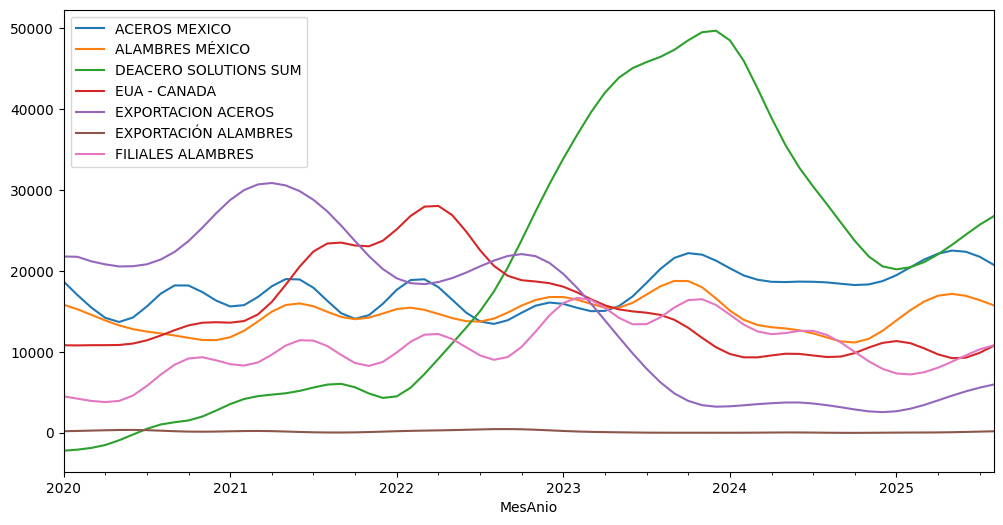

In [191]:
VARILLA_TREND["BU"].round(1).plot( figsize=(12, 6))
VARILLA_TREND["BU"]

<Axes: ylabel='MesAnio'>

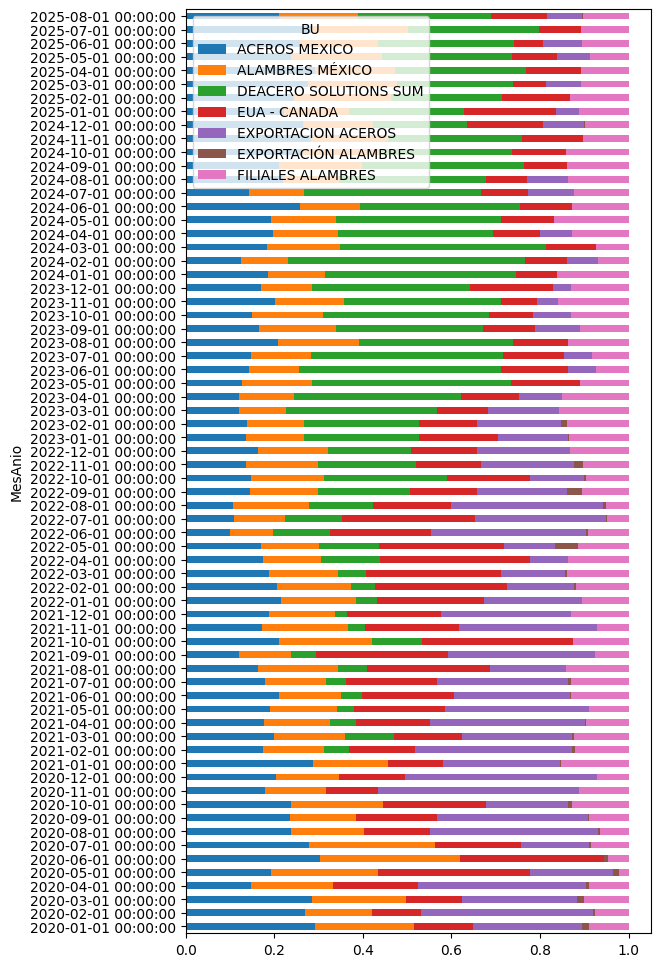

In [10]:
VARILLA["BU"].apply(lambda x:x / VARILLA["BU"].sum(axis = 1)).plot(kind = "barh", stacked = True, figsize=(6, 12))

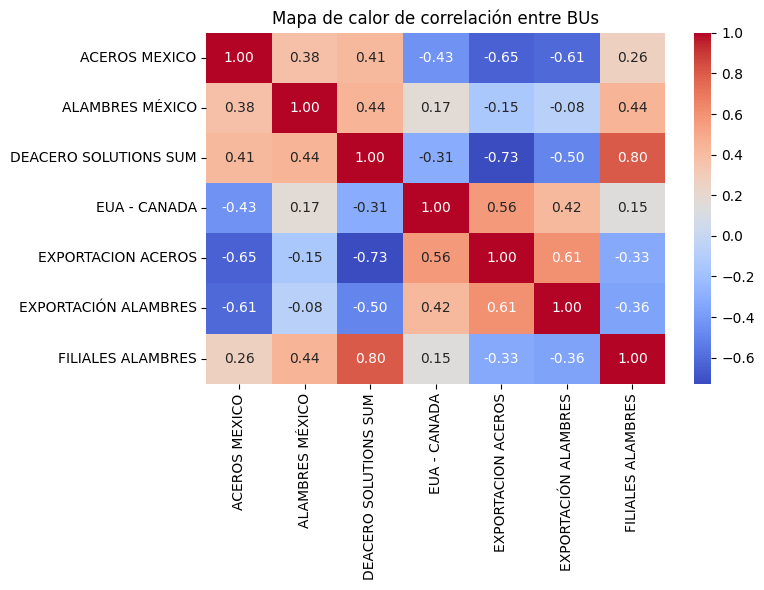

In [195]:
# Calcular la matriz de correlación
correlation_matrix = VARILLA_TREND["BU"].corr(method="pearson")

# Generar el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlación entre BUs")
plt.tight_layout()

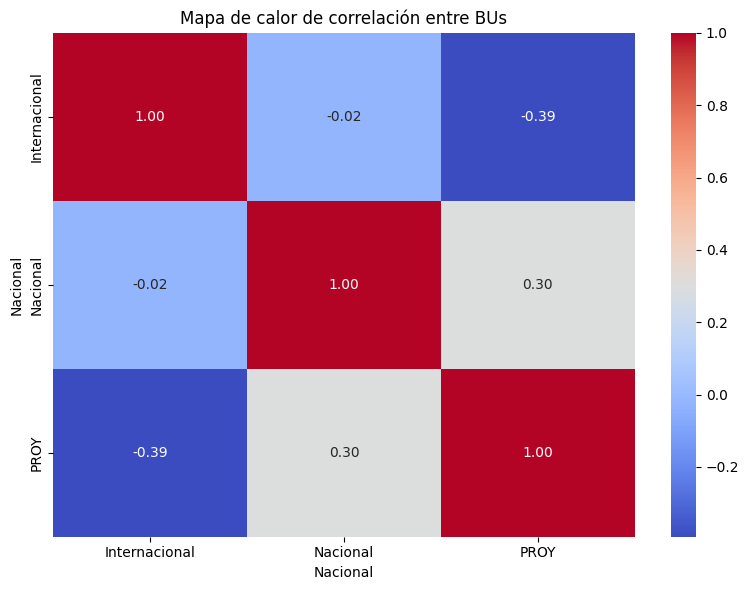

In [126]:
VARILLA = FACT[~FACT.BU.isin(["2DROP"])][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["Nacional","MesAnio"]).toneladas_facturadas.sum().unstack(["Nacional"]).round(1)

# Calcular la matriz de correlación
correlation_matrix = VARILLA.corr(method="spearman")

# Generar el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor de correlación entre BUs")
plt.tight_layout()

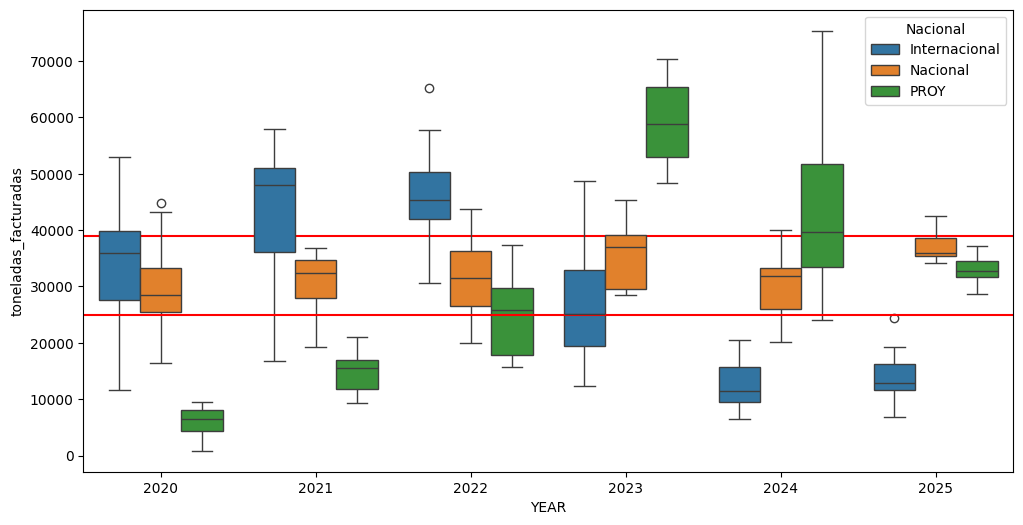

In [61]:
import seaborn as sns
box = VARILLA["NACIONAL"].melt(ignore_index = False, var_name ="Nacional", value_name = "toneladas_facturadas").reset_index()
box["YEAR"] = box.MesAnio.dt.year
box["Q"] = box.MesAnio.dt.quarter

plt.figure(figsize=(12, 6))
plt.axhline(y = 39000, color='r', linestyle='-')
sns.boxplot(box, x ="YEAR", y = "toneladas_facturadas", hue = "Nacional")
plt.axhline(y = 25000, color='r', linestyle='-')

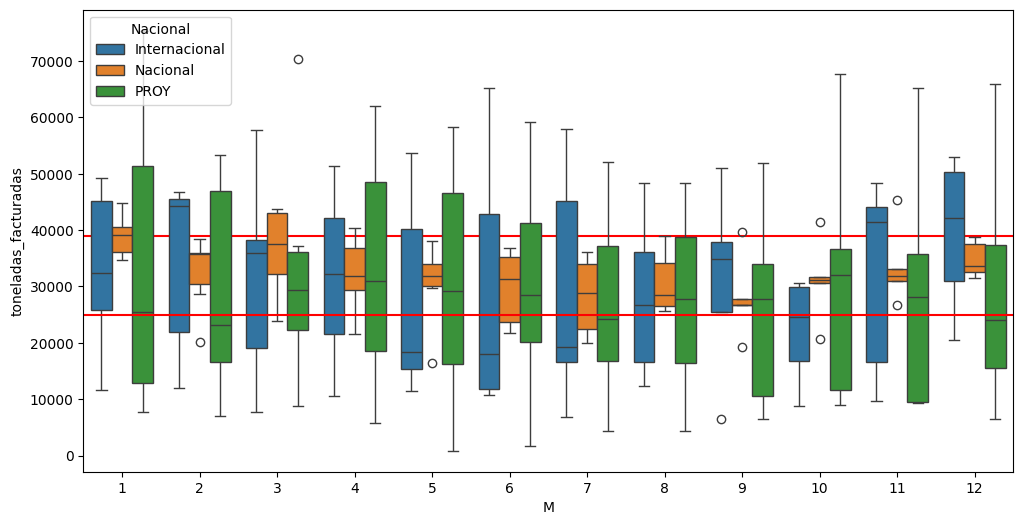

In [296]:
import seaborn as sns
box = VARILLA["NACIONAL"].melt(ignore_index = False, var_name ="Nacional", value_name = "toneladas_facturadas").reset_index()
box["YEAR"] = box.MesAnio.dt.year
box["Q"] = box.MesAnio.dt.quarter 
box["M"] = box.MesAnio.dt.month 

plt.figure(figsize=(12, 6))
plt.axhline(y = 39000, color='r', linestyle='-')
sns.boxplot(box, x ="M", y = "toneladas_facturadas", hue = "Nacional")
plt.axhline(y = 25000, color='r', linestyle='-')

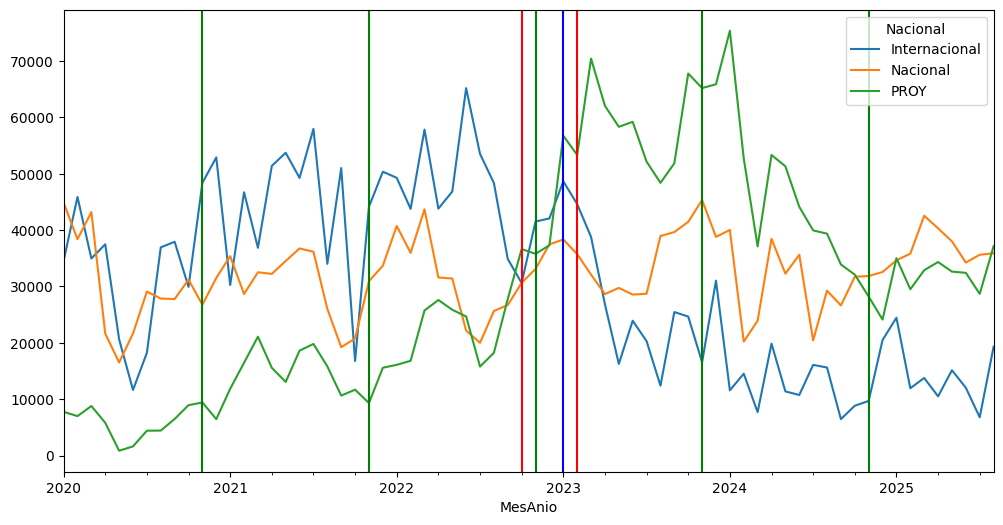

In [303]:
FACT[~FACT.BU.isin(["2DROP"])][(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["Nacional","MesAnio"]).toneladas_facturadas.sum().unstack(["Nacional"]).round(1).plot(figsize=(12,6))
plt.axvline(x = "2022-10-01", color='r', linestyle='-')
plt.axvline(x = "2023-01-01", color='b', linestyle='-')
plt.axvline(x = "2023-02-01", color='r', linestyle='-')
plt.axvline(x = "2023-11-01", color='g', linestyle='-')
plt.axvline(x = "2024-11-01", color='g', linestyle='-')
plt.axvline(x = "2022-11-01", color='g', linestyle='-')
plt.axvline(x = "2021-11-01", color='g', linestyle='-')
plt.axvline(x = "2020-11-01", color='g', linestyle='-')

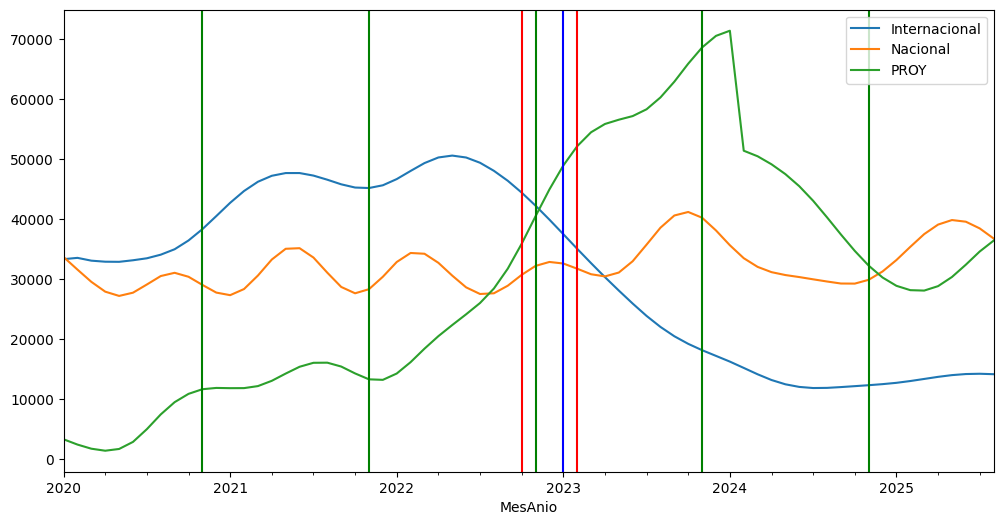

In [304]:
VARILLA_TREND["NACIONAL"].round(1).plot(figsize=(12,6))
plt.axvline(x = "2022-10-01", color='r', linestyle='-')
plt.axvline(x = "2023-01-01", color='b', linestyle='-')
plt.axvline(x = "2023-02-01", color='r', linestyle='-')
plt.axvline(x = "2023-11-01", color='g', linestyle='-')
plt.axvline(x = "2024-11-01", color='g', linestyle='-')
plt.axvline(x = "2022-11-01", color='g', linestyle='-')
plt.axvline(x = "2021-11-01", color='g', linestyle='-')
plt.axvline(x = "2020-11-01", color='g', linestyle='-')

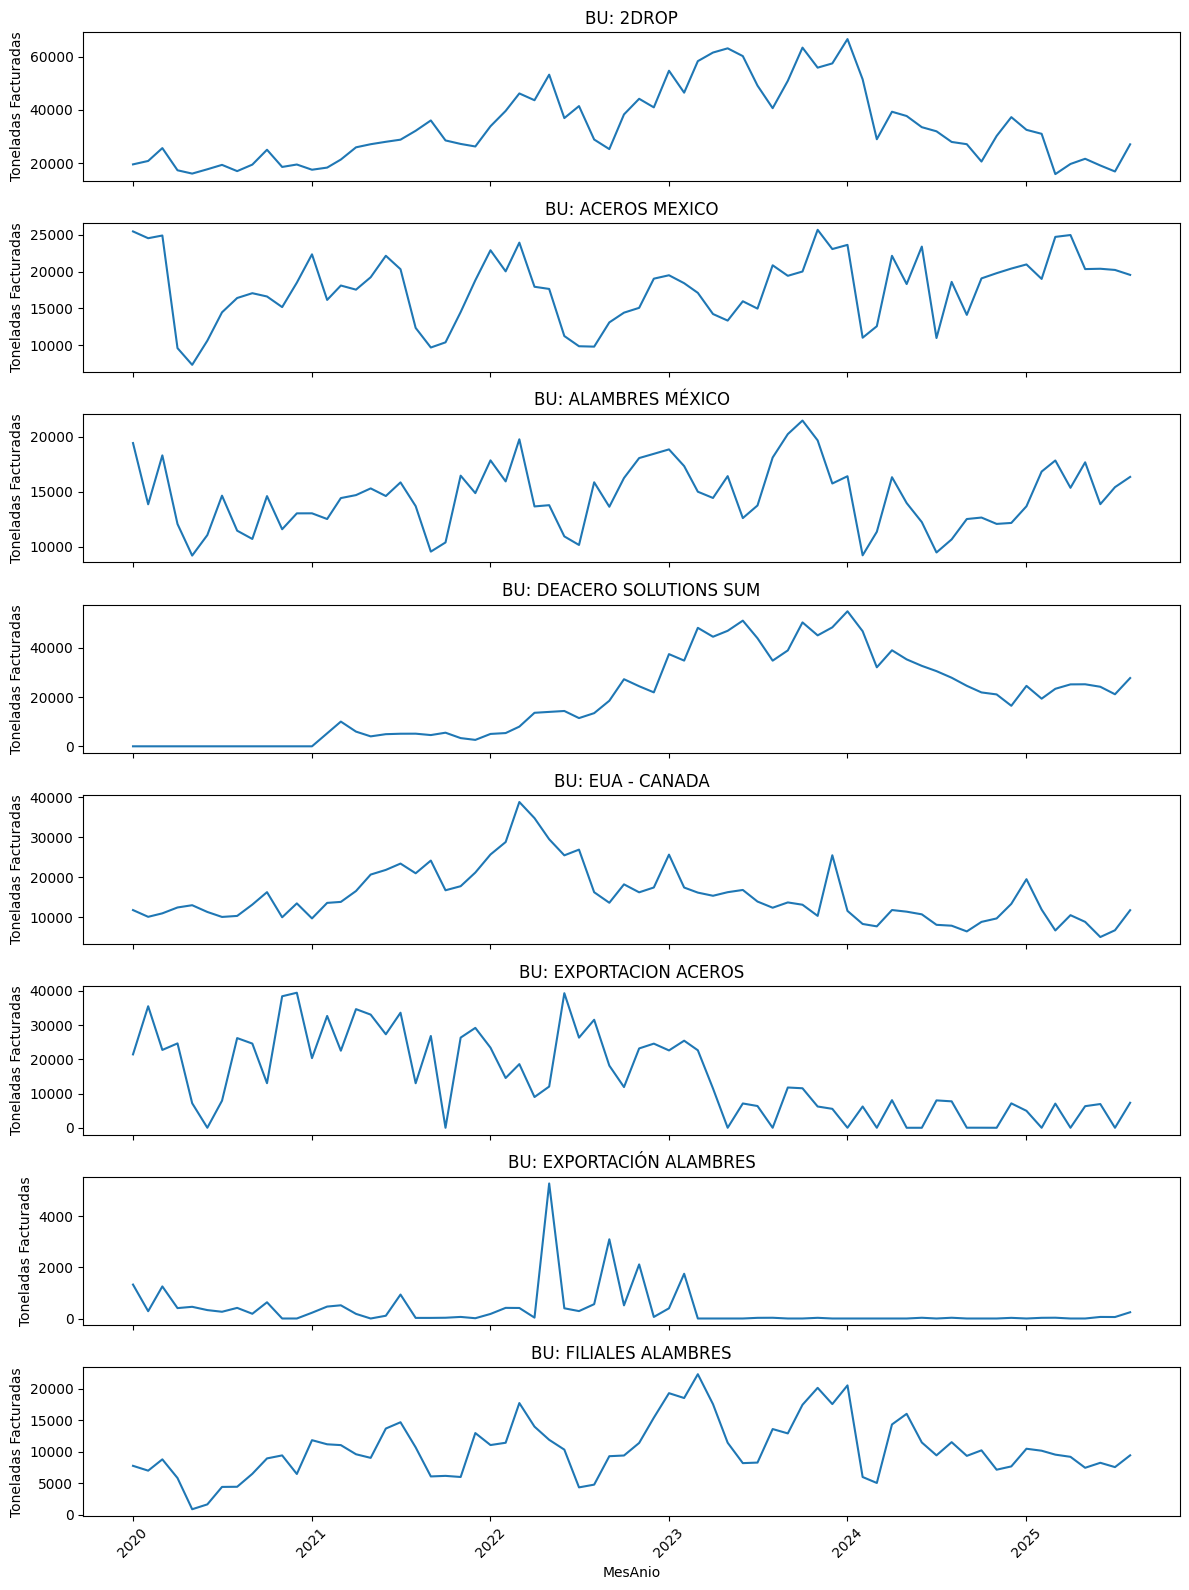

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
VARILLA = FACT[(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["BU","MesAnio"]).toneladas_facturadas.sum().reset_index()

bus = VARILLA.BU.unique()
# Crear subplots
fig, axes = plt.subplots(len(bus), 1, figsize=(12, 2 * len(bus)), sharex=True)

# Graficar cada BU en su subplot
for i, bu in enumerate(bus):
    data_bu = VARILLA[VARILLA.BU == bu]
    sns.lineplot(data=data_bu, x="MesAnio", y="toneladas_facturadas", ax=axes[i])
    axes[i].set_title(f"BU: {bu}")
    axes[i].set_ylabel("Toneladas Facturadas")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

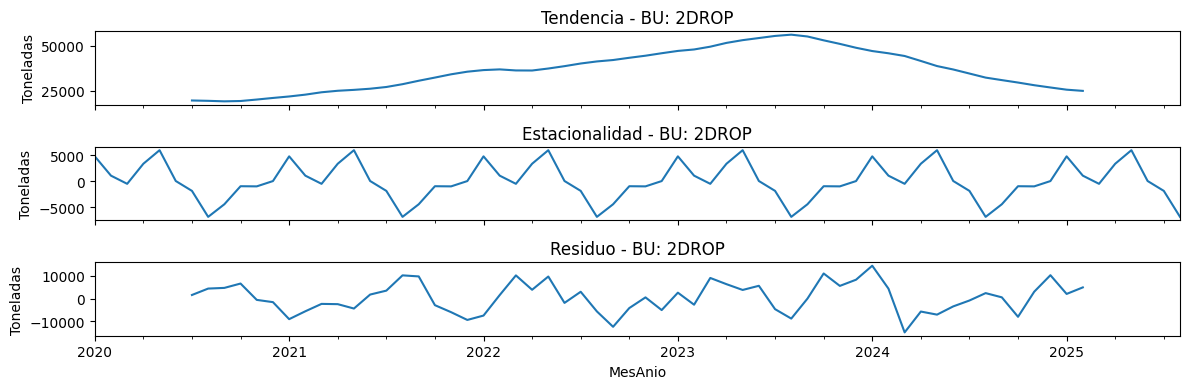

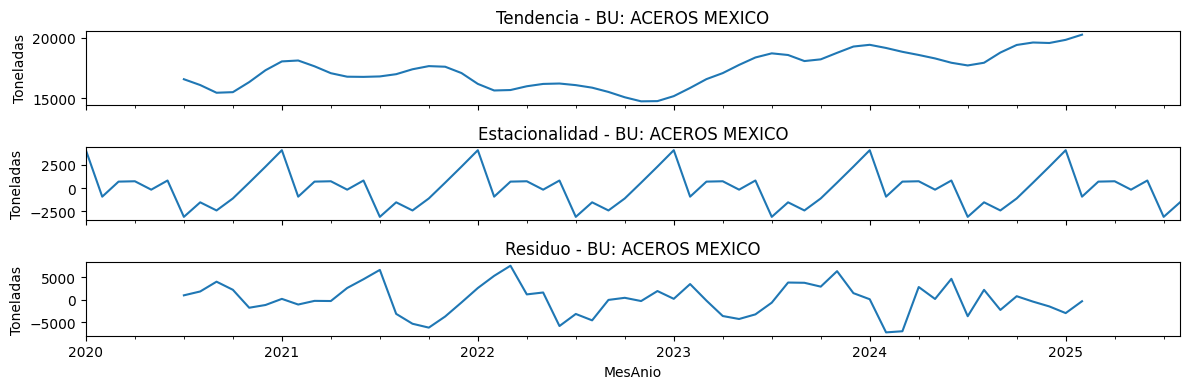

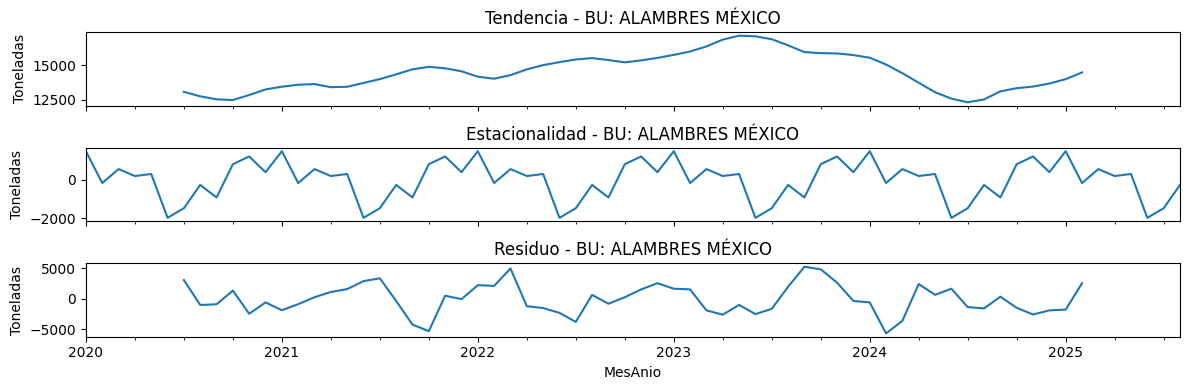

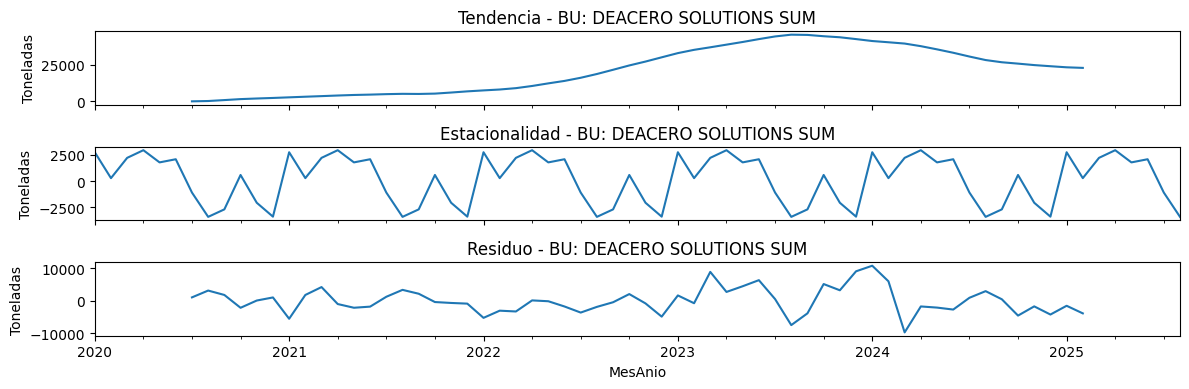

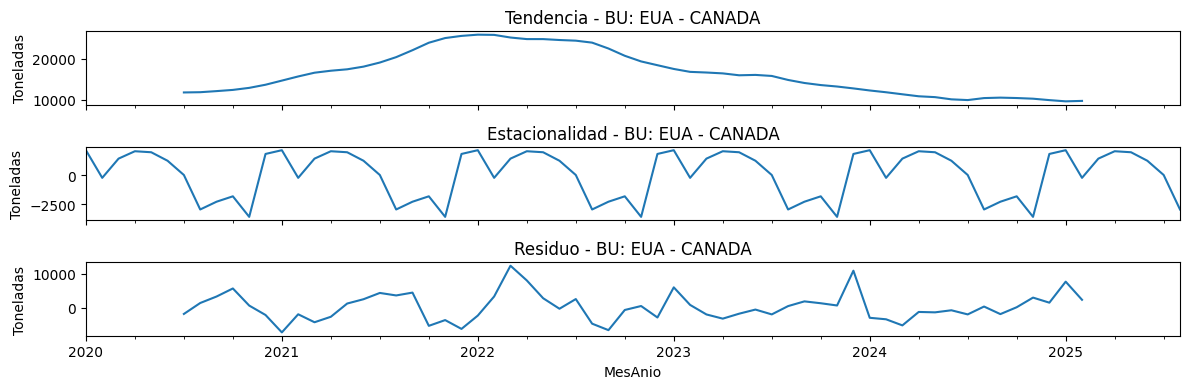

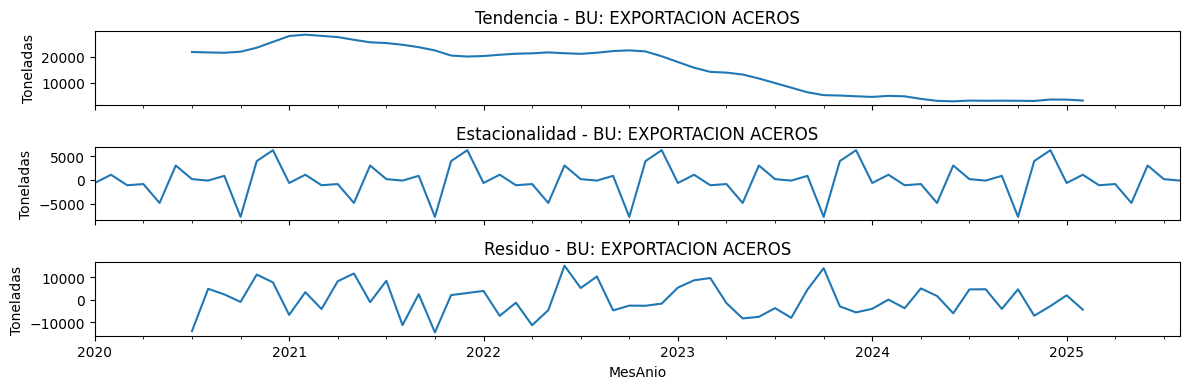

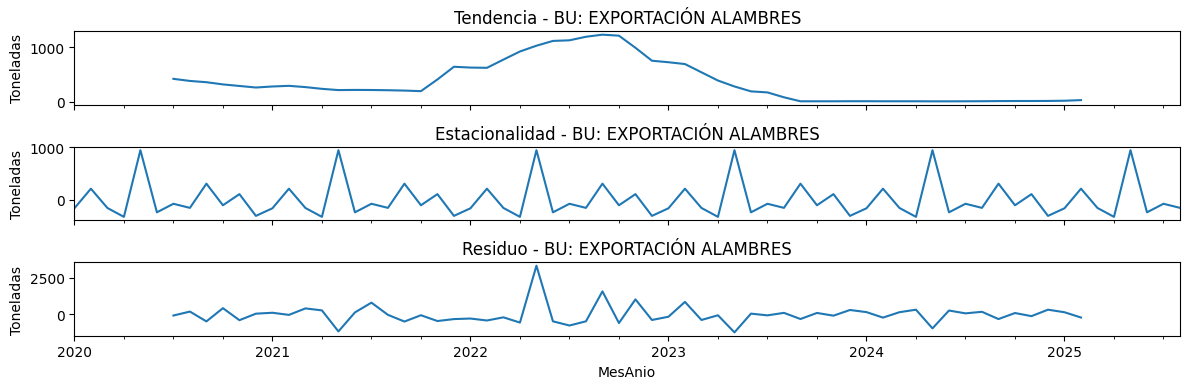

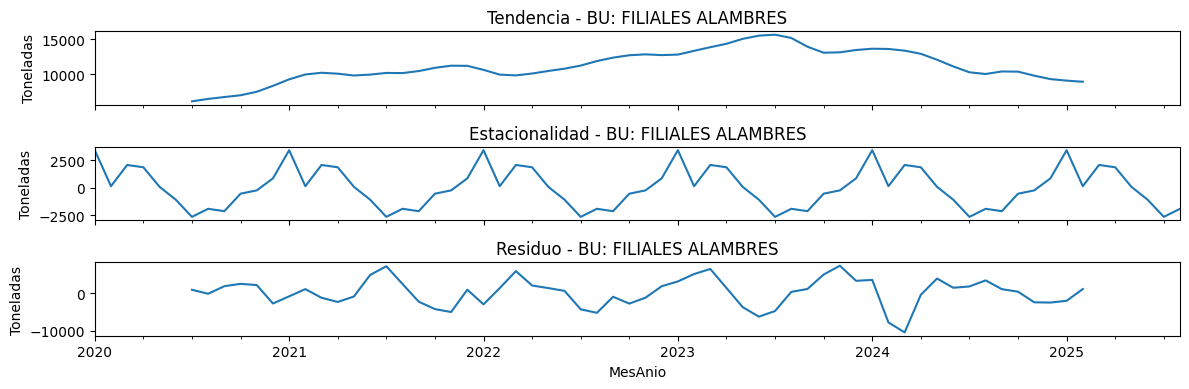

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Crear subplots para cada BU
for bu in bus:
    data_bu = VARILLA[VARILLA.BU == bu].set_index("MesAnio").sort_index()
    
    # Reindexar con frecuencia mensual para asegurar continuidad
    data_bu = data_bu.resample("MS").sum()

    # Descomposición de la serie temporal
    decomposition = seasonal_decompose(data_bu["toneladas_facturadas"], model='additive', period=12)

    # Graficar los componentes
    fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True)
    decomposition.trend.plot(ax=axes[0], title=f"Tendencia - BU: {bu}")
    decomposition.seasonal.plot(ax=axes[1], title=f"Estacionalidad - BU: {bu}")
    decomposition.resid.plot(ax=axes[2], title=f"Residuo - BU: {bu}")
    axes[0].set_ylabel("Toneladas")
    axes[1].set_ylabel("Toneladas")
    axes[2].set_ylabel("Toneladas")
    plt.tight_layout()
    plt.show()


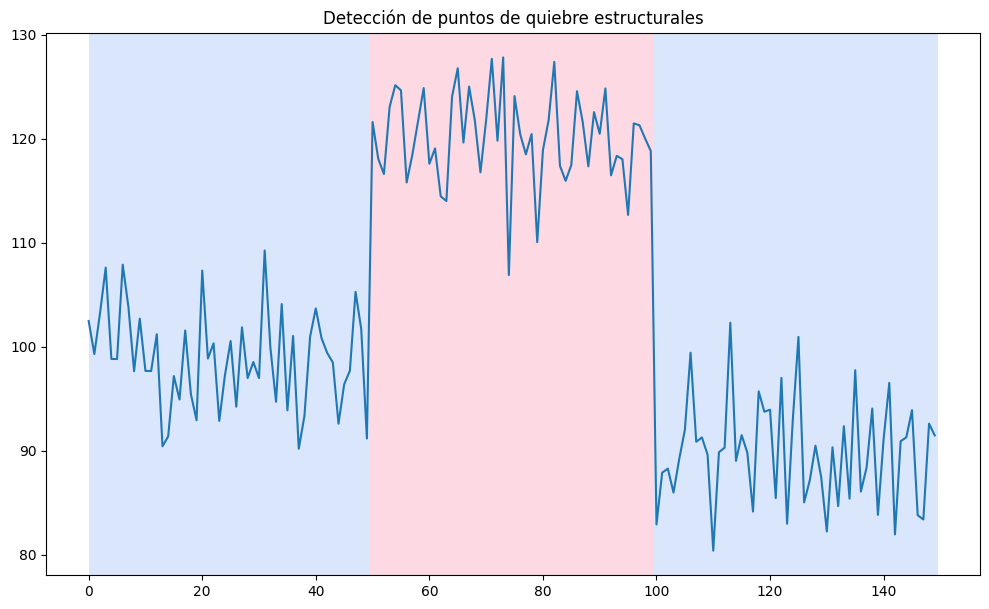

In [128]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

# Supongamos que tienes una serie temporal en un DataFrame
# df = pd.read_csv("tu_archivo.csv")
# serie = df["toneladas_facturadas"].values

# Simulación de una serie con quiebres estructurales
np.random.seed(42)
serie = np.concatenate([
    np.random.normal(loc=100, scale=5, size=50),
    np.random.normal(loc=120, scale=5, size=50),
    np.random.normal(loc=90, scale=5, size=50)
])

# Método de detección: Pelt con modelo 'rbf' (puede usar también 'l1', 'l2', 'normal', etc.)
model = "rbf"
algo = rpt.Pelt(model=model).fit(serie)
breakpoints = algo.predict(pen=10)

# Visualización
rpt.display(serie, breakpoints, figsize=(10, 6))
plt.title("Detección de puntos de quiebre estructurales")
plt.show()


<Axes: xlabel='MesAnio'>

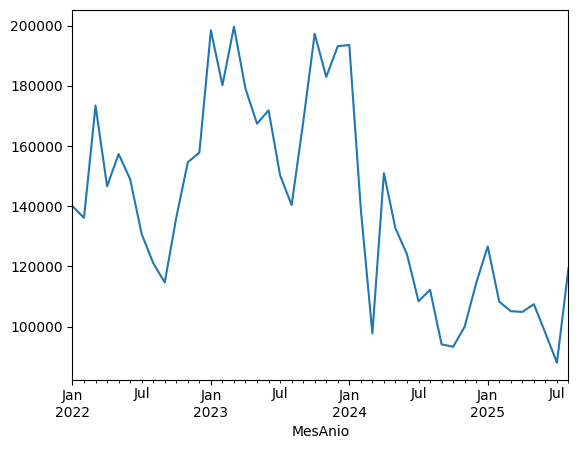

In [ ]:
FACT[(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby("MesAnio").toneladas_facturadas.sum().round(1).plot()

<Axes: xlabel='MesAnio'>

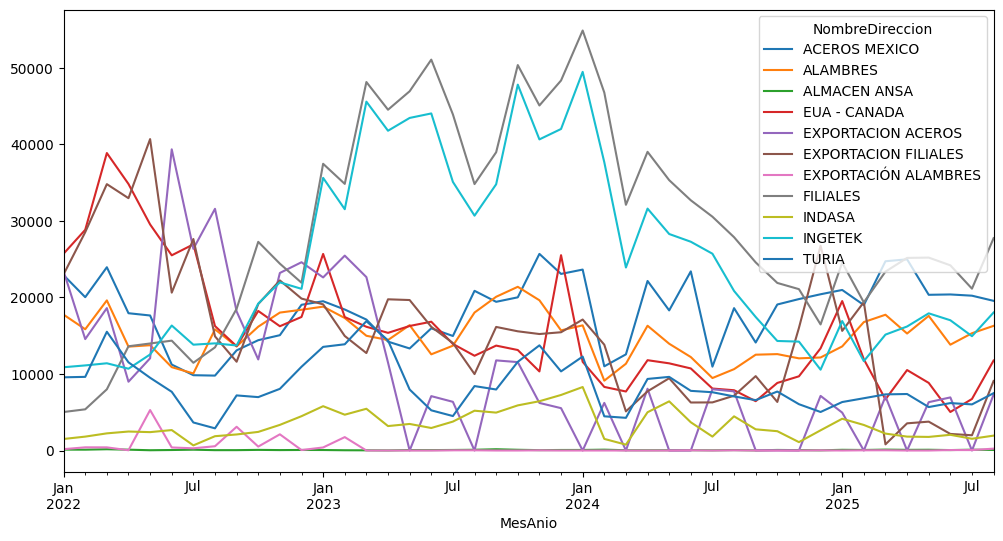

In [ ]:
FACT[(FACT["NombreGrupoEstadistico1"] == "VARILLA") & (FACT.MesAnio <="2025-08-01" )].groupby(["NombreDireccion","MesAnio"]).toneladas_facturadas.sum().unstack(["NombreDireccion"]).round(1).plot(figsize=(12,6))

<Axes: xlabel='MesAnio'>

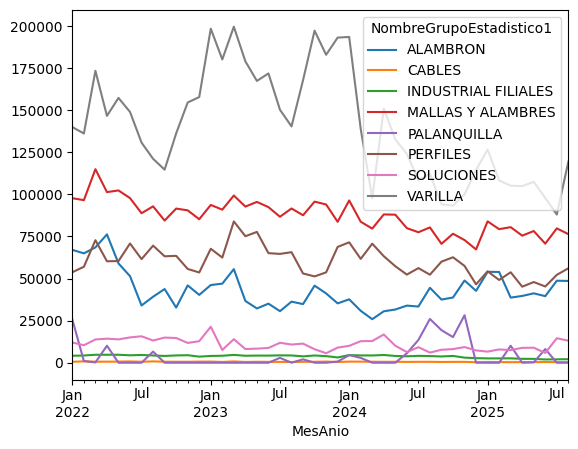

In [8]:
FACT[(FACT.NombreGrupo != "'TRASPASOS E INTEREMPRESAS") & (FACT.MesAnio <= '2025-08-01') & (FACT.id.isin(ids.index))].groupby(["NombreGrupoEstadistico1", "MesAnio"]).toneladas_facturadas.sum().unstack("NombreGrupoEstadistico1").plot()

<Axes: xlabel='MesAnio'>

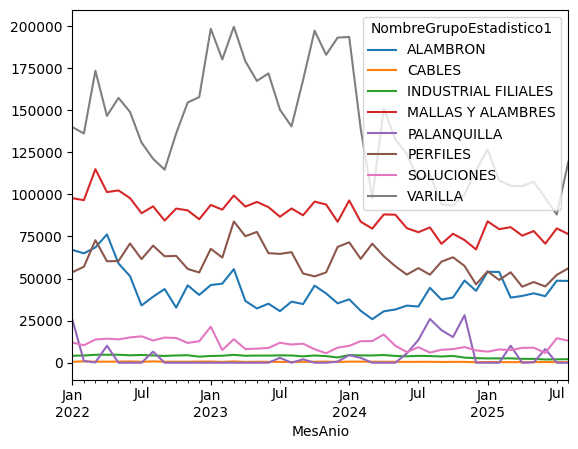

In [11]:
FACT[(FACT.NombreGrupo != "'TRASPASOS E INTEREMPRESAS") &(FACT.MesAnio <= '2025-08-01') & (FACT.id.isin(ids.index)) ].groupby(["NombreGrupoEstadistico1", "MesAnio"]).toneladas_facturadas.sum().unstack("NombreGrupoEstadistico1").plot()

In [12]:
FACT[(FACT.NombreGrupo != "'TRASPASOS E INTEREMPRESAS") &(FACT.MesAnio <= '2025-08-01') & (FACT.id.isin(ids.index)) ].groupby("MesAnio").toneladas_facturadas.sum()


MesAnio
2022-01-01    400926.736036
2022-02-01    371230.931655
2022-03-01    449040.646366
2022-04-01    414268.369778
2022-05-01    398317.759008
2022-06-01    389261.657765
2022-07-01    336028.094267
2022-08-01    347722.123110
2022-09-01    325693.552119
2022-10-01    343666.947956
2022-11-01    363577.961090
2022-12-01    354029.341331
2023-01-01    432100.745120
2023-02-01    392744.012168
2023-03-01    457854.499541
2023-04-01    396384.362510
2023-05-01    386073.490818
2023-06-01    378005.023561
2023-07-01    351871.392322
2023-08-01    349552.573532
2023-09-01    361003.992051
2023-10-01    402905.724828
2023-11-01    382026.327124
2023-12-01    394154.720177
2024-01-01    418877.551045
2024-02-01    335834.142397
2024-03-01    291784.414291
2024-04-01    354808.428502
2024-05-01    324238.577945
2024-06-01    306498.716040
2024-07-01    302923.569824
2024-08-01    325952.967005
2024-09-01    293534.503383
2024-10-01    299173.119524
2024-11-01    320248.061890
2024-12-01  

In [ ]:
# -*- coding: utf-8 -*-
"""
Pronóstico de demanda de varilla con LightGBM:
- Feature engineering (lags y ventanas móviles)
- Validación cruzada temporal (backtesting con ventana expansiva)
- Optimización de hiperparámetros con Optuna
- Entrenamiento repetido (ensembles por seeds) y pronóstico recursivo multi‑paso

Requisitos:
    pip install lightgbm optuna pandas numpy scikit-learn

Entrada esperada:
    Un DataFrame 'df' con al menos:
        - 'fecha' (datetime64[ns])
        - 'y' (float): demanda de varilla (target)
    Opcional:
        - 'id' (str/int): si hay múltiples series (producto/sucursal/etc.)
        - Otras variables exógenas ya alineadas temporalmente (numéricas o categóricas)

Nota:
    - Métrica principal: sMAPE (robusta a ceros, común en demanda intermitente)
    - No hay fugas: los lags/ventanas se calculan sólo con pasado.
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from typing import List, Optional, Tuple, Dict
from dataclasses import dataclass
import lightgbm as lgb
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# ==============================
# Utilidades de métricas y fechas
# ==============================

def smape(y_true: np.ndarray, y_pred: np.ndarray, epsilon: float = 1e-6) -> float:
    """
    Symmetric Mean Absolute Percentage Error (sMAPE), en porcentaje [0, 200].
    Robusta a ceros.
    """
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = (np.abs(y_true) + np.abs(y_pred)).clip(min=epsilon)
    return float(np.mean(200.0 * np.abs(y_pred - y_true) / denom))


def infer_frequency(dates: pd.Series) -> str:
    """
    Intenta inferir la frecuencia temporal (p.ej. 'D', 'W', 'M').
    Si falla, asume diaria.
    """
    dates_sorted = pd.Series(pd.to_datetime(dates.unique())).sort_values()
    try:
        freq = pd.infer_freq(dates_sorted)
        return freq if freq is not None else "D"
    except Exception:
        return "D"


# ==============================
# Feature engineering
# ==============================

def add_time_features(df: pd.DataFrame, date_col: str = "fecha") -> pd.DataFrame:
    """Agrega features temporales estándar (no causa fuga)."""
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    d["year"] = d[date_col].dt.year
    d["quarter"] = d[date_col].dt.quarter
    d["month"] = d[date_col].dt.month
    d["weekofyear"] = d[date_col].dt.isocalendar().week.astype(int)
    d["day"] = d[date_col].dt.day
    d["dayofweek"] = d[date_col].dt.dayofweek
    d["is_month_start"] = d[date_col].dt.is_month_start.astype(int)
    d["is_month_end"] = d[date_col].dt.is_month_end.astype(int)
    d["is_quarter_start"] = d[date_col].dt.is_quarter_start.astype(int)
    d["is_quarter_end"] = d[date_col].dt.is_quarter_end.astype(int)
    return d


def make_lag_features(
    df: pd.DataFrame,
    target_col: str = "y",
    lags: List[int] = [1, 2, 3, 7, 14, 28],
    roll_windows: List[int] = [7, 14, 28],
    id_col: Optional[str] = None,
    date_col: str = "fecha"
) -> pd.DataFrame:
    """
    Genera lags y estadísticas móviles del target por serie (id) o globalmente si no hay id.
    """
    d = df.copy()
    d = d.sort_values([id_col, date_col] if id_col in d.columns else [date_col])

    group_keys = [id_col] if (id_col is not None and id_col in d.columns) else None
    gb = d.groupby(group_keys) if group_keys else [(None, d)]

    frames = []
    for _, g in gb if group_keys else gb:
        g2 = g.copy()
        for L in lags:
            g2[f"lag_{L}"] = g2[target_col].shift(L)
        for W in roll_windows:
            # Medidas robustas y de tendencia
            g2[f"rmean_{W}"] = g2[target_col].shift(1).rolling(W).mean()
            g2[f"rmedian_{W}"] = g2[target_col].shift(1).rolling(W).median()
            g2[f"rstd_{W}"] = g2[target_col].shift(1).rolling(W).std()
            g2[f"rmin_{W}"] = g2[target_col].shift(1).rolling(W).min()
            g2[f"rmax_{W}"] = g2[target_col].shift(1).rolling(W).max()
        frames.append(g2)

    dd = pd.concat(frames, axis=0)
    return dd


def prepare_dataset(
    df: pd.DataFrame,
    target_col: str = "y",
    id_col: Optional[str] = "id",
    date_col: str = "fecha",
    lags: List[int] = [1, 2, 3, 7, 14, 28],
    roll_windows: List[int] = [7, 14, 28],
    drop_na: bool = True
) -> pd.DataFrame:
    """
    Pipeline de features: temporales + lags/ventanas.
    """
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    d = add_time_features(d, date_col=date_col)
    d = make_lag_features(d, target_col=target_col, lags=lags, roll_windows=roll_windows, id_col=id_col, date_col=date_col)

    if drop_na:
        d = d.dropna().reset_index(drop=True)
    return d


# ==============================
# Folds de validación temporal (backtesting)
# ==============================

def build_rolling_origin_folds(
    df: pd.DataFrame,
    date_col: str,
    n_splits: int,
    horizon: int,
    min_train_periods: int = 60
) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Construye n_splits folds de backtesting con ventana expansiva y validación de longitud 'horizon' (pasos).
    - Usa fechas globales (funciona para series múltiples alineadas por fecha).
    - Cada fold: train = [inicio : t), valid = [t : t+horizon)
    """
    dates = pd.Series(pd.to_datetime(df[date_col].unique())).sort_values().reset_index(drop=True)
    if len(dates) < (n_splits * horizon + min_train_periods):
        raise ValueError("No hay suficientes períodos para los folds solicitados. Reduce n_splits/horizon o usa más datos.")

    start_val_idx = len(dates) - n_splits * horizon
    folds = []
    for i in range(n_splits):
        train_end_idx = start_val_idx + i * horizon
        valid_start_idx = train_end_idx
        valid_end_idx = valid_start_idx + horizon

        train_dates = set(dates.iloc[:train_end_idx].tolist())
        valid_dates = set(dates.iloc[valid_start_idx:valid_end_idx].tolist())

        train_idx = df[date_col].isin(train_dates).values.nonzero()[0]
        valid_idx = df[date_col].isin(valid_dates).values.nonzero()[0]
        # Asegurar mínimo de entrenamiento
        if len(train_dates) < min_train_periods:
            continue
        folds.append((train_idx, valid_idx))

    if len(folds) == 0:
        raise ValueError("No se pudieron construir folds válidos. Ajusta parámetros.")
    return folds

# ==============================
# Entrenamiento con Optuna
# ==============================

@dataclass
class TrainingConfig:
    target_col: str = "y"
    id_col: Optional[str] = "id"
    date_col: str = "fecha"
    n_splits: int = 5
    horizon: int = 4
    min_train_periods: int = 60
    n_trials: int = 50
    early_stopping_rounds: int = 200
    num_boost_round: int = 5000
    learning_rate_bounds: Tuple[float, float] = (1e-3, 0.2)
    seeds_for_ensemble: List[int] = (42, 202, 777)  # cuántas veces entrenas (ensembles)
    lags: List[int] = (1, 2, 3, 7, 14, 28)
    roll_windows: List[int] = (7, 14, 28)

def get_feature_target_matrices(
    df: pd.DataFrame,
    config: TrainingConfig
) -> Tuple[pd.DataFrame, pd.Series, List[str], List[str]]:
    """
    Devuelve X, y y listas de columnas numéricas/categóricas para LightGBM.
    """
    # Columnas a excluir (fecha y target)
    exclude = {config.date_col, config.target_col}

    # Detección de categóricas (id como categoría si existe; el resto inferido por dtype)
    cat_cols = []
    if config.id_col and config.id_col in df.columns:
        # Convertir id a categoría estable (LabelEncoder deja int, mejor dtype category)
        if not pd.api.types.is_categorical_dtype(df[config.id_col]):
            df[config.id_col] = df[config.id_col].astype("category")
        cat_cols.append(config.id_col)

    # Otras categóricas por dtype 'category'
    for c in df.columns:
        if c not in exclude and pd.api.types.is_categorical_dtype(df[c]) and c not in cat_cols:
            cat_cols.append(c)

    # Todas las features
    feature_cols = [c for c in df.columns if c not in exclude]

    X = df[feature_cols].copy()
    y = df[config.target_col].astype(float).copy()

    # LightGBM maneja pandas category nativamente si se pasa por nombre
    num_cols = [c for c in feature_cols if c not in cat_cols]
    return X, y, num_cols, cat_cols


def optuna_objective_factory(
    df_features: pd.DataFrame,
    config: TrainingConfig
):
    """
    Crea una función objetivo para Optuna que hace backtesting con n_splits folds
    y retorna el promedio de sMAPE (minimizar).
    """
    X, y, num_cols, cat_cols = get_feature_target_matrices(df_features, config)
    folds = build_rolling_origin_folds(df_features, config.date_col, config.n_splits, config.horizon, config.min_train_periods)

    def objective(trial: optuna.Trial) -> float:
        # Espacio de hiperparámetros
        params = {
            "objective": "mae",  # robusto para demanda
            "metric": "mae",
            "boosting_type": "gbdt",
            "verbosity": -1,
            "n_estimators": config.num_boost_round,
            "learning_rate": trial.suggest_float("learning_rate", *config.learning_rate_bounds, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 15, 255, step=1),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),            # bagging_fraction
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  # feature_fraction
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "random_state": 42,
        }

        fold_scores = []
        for (tr_idx, va_idx) in folds:
            X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
            X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

            model = lgb.LGBMRegressor(**params)
            model.fit(
                X_tr,
                y_tr,
                eval_set=[(X_va, y_va)],
                eval_metric="l1",
                callbacks=[
                    lgb.early_stopping(stopping_rounds=config.early_stopping_rounds, verbose=False)
                ],
                categorical_feature=cat_cols if len(cat_cols) > 0 else "auto"
            )
            y_hat = model.predict(X_va, num_iteration=model.best_iteration_)
            fold_scores.append(smape(y_va.values, y_hat))
        return float(np.mean(fold_scores))

    return objective


# ==============================
# Forecast recursivo multi‑paso
# ==============================

def recursive_forecast(
    df_full: pd.DataFrame,
    model: lgb.LGBMRegressor,
    horizon: int,
    config: TrainingConfig
) -> pd.DataFrame:
    
    """
    Genera pronóstico recursivo h pasos usando las mismas transformaciones.
    - Para múltiples series (id), pronostica cada paso para todos los ids y actualiza lags.
    - Asume que las features temporales del futuro se pueden derivar de la fecha.
    """

    id_col, date_col, target_col = config.id_col, config.date_col, config.target_col
    lags = list(config.lags)
    rolls = list(config.roll_windows)

    # Orden y última fecha
    df_hist = df_full.sort_values([id_col, date_col] if id_col in df_full.columns else [date_col]).copy()
    last_date = pd.to_datetime(df_hist[date_col].max())
    freq = infer_frequency(df_hist[date_col])

    # Fechas futuras
    future_dates = pd.date_range(start=last_date, periods=horizon+1, freq=freq, inclusive="right")

    # Contenedor de predicciones
    preds_list = []

    # Mantenemos un "buffer" histórico que vamos extendiendo con predicciones
    df_buffer = df_hist.copy()

    for step, dt in enumerate(future_dates, start=1):
        # Crear frame "plantilla" con filas de todos los ids en la fecha dt
        if id_col and id_col in df_buffer.columns:
            ids = df_buffer[id_col].unique()
            df_step = pd.DataFrame({date_col: dt, id_col: ids})
        else:
            df_step = pd.DataFrame({date_col: [dt]})

        # No conocemos y futura; ponemos NaN temporalmente
        df_step[target_col] = np.nan

        # Unimos a buffer y re-creamos features lags/rollings correctamente
        df_tmp = pd.concat([df_buffer, df_step], axis=0, ignore_index=True)
        df_tmp = prepare_dataset(
            df_tmp,
            target_col=target_col,
            id_col=id_col,
            date_col=date_col,
            lags=lags,
            roll_windows=rolls,
            drop_na=False
        )

        # Tomar sólo la fecha actual para predecir (después de features)
        X_all, _, _, cat_cols = get_feature_target_matrices(df_tmp, config)
        mask_current = df_tmp[date_col] == dt
        X_current = X_all.loc[mask_current].copy()

        # Remover columnas target del set por seguridad (ya excluidas en get_feature_target_matrices)
        y_hat = model.predict(X_current, num_iteration=getattr(model, "best_iteration_", None))

        # Reinyectar predicción al buffer para poder generar lags del siguiente paso
        df_tmp.loc[mask_current, target_col] = y_hat
        # Actualizar buffer sólo con columnas originales mínimas (fecha, id, y, + exógenas si hubiera)
        keep_cols = [c for c in df_hist.columns]  # conserva esquema original
        df_buffer = pd.concat([df_buffer, df_tmp.loc[mask_current, keep_cols]], axis=0, ignore_index=True)

        # Guardar predicciones
        if id_col and id_col in df_buffer.columns:
            out = df_tmp.loc[mask_current, [date_col, id_col]].copy()
        else:
            out = df_tmp.loc[mask_current, [date_col]].copy()
        out["y_hat"] = y_hat
        preds_list.append(out)

    df_preds = pd.concat(preds_list, axis=0).reset_index(drop=True)
    return df_preds

# ==============================
# Pipeline principal
# ==============================

def train_and_forecast(
    df: pd.DataFrame,
    horizon: int = 4,
    n_splits: int = 5,
    n_trials: int = 50,
    seeds_for_ensemble: List[int] = (42, 202, 777),
    id_col: Optional[str] = "id",
    date_col: str = "fecha",
    target_col: str = "y",
    lags: List[int] = (1, 2, 3, 7, 14, 28),
    roll_windows: List[int] = (7, 14, 28),
    min_train_periods: int = 60,
    num_boost_round: int = 5000,
    early_stopping_rounds: int = 200

) -> Dict[str, any]:
    """
    Entrena LightGBM con Optuna y genera pronóstico h pasos.
    - Hace HPO con backtesting
    - Reentrena un ensemble (múltiples seeds) con mejores hiperparámetros
    - Promedia predicciones del ensemble

    Retorna:
        {
          "best_params": dict,
          "best_score_smape": float,
          "models": List[LGBMRegressor],
          "forecast": DataFrame (fecha, [id], y_hat)
        }
    """

    # Asegurar tipos
    dfin = df.copy()
    dfin[date_col] = pd.to_datetime(dfin[date_col])

    # Config
    config = TrainingConfig(
        target_col=target_col,
        id_col=id_col if id_col in dfin.columns else None,
        date_col=date_col,
        n_splits=n_splits,
        horizon=horizon,
        min_train_periods=min_train_periods,
        n_trials=n_trials,
        early_stopping_rounds=early_stopping_rounds,
        num_boost_round=num_boost_round,
        seeds_for_ensemble=list(seeds_for_ensemble),
        lags=list(lags),
        roll_windows=list(roll_windows)
    )

    # Features para HPO (dropna=True para evitar fugas durante CV)
    df_features = prepare_dataset(
        dfin,
        target_col=config.target_col,
        id_col=config.id_col,
        date_col=config.date_col,
        lags=config.lags,
        roll_windows=config.roll_windows,
        drop_na=True
    )

    # OPTUNA: objetivo
    objective = optuna_objective_factory(df_features, config)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=config.n_trials, show_progress_bar=False)

    best_params = study.best_trial.params
    # Congelar hiperparámetros completos para LightGBM
    best_full_params = {
        "objective": "mae",
        "metric": "mae",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "n_estimators": config.num_boost_round,
        "learning_rate": best_params["learning_rate"],
        "num_leaves": best_params["num_leaves"],
        "max_depth": best_params["max_depth"],
        "min_child_samples": best_params["min_child_samples"],
        "min_split_gain": best_params["min_split_gain"],
        "subsample": best_params["subsample"],
        "colsample_bytree": best_params["colsample_bytree"],
        "reg_alpha": best_params["reg_alpha"],
        "reg_lambda": best_params["reg_lambda"],
    }

    # Reentrenar modelos con mejores hiperparámetros y distintos seeds (ensembles)
    X_all, y_all, _, cat_cols = get_feature_target_matrices(df_features, config)

    models = []
    for seed in config.seeds_for_ensemble:
        p = best_full_params.copy()
        p["random_state"] = seed
        model = lgb.LGBMRegressor(**p)
        # Para entrenar final, usamos early stopping contra un holdout al final:
        # Tomamos últimas 'horizon' fechas como pseudo-validación si es posible.
        folds_final = build_rolling_origin_folds(df_features, config.date_col, n_splits=1, horizon=config.horizon, min_train_periods=config.min_train_periods)
        tr_idx, va_idx = folds_final[0]
        model.fit(
            X_all.iloc[tr_idx],
            y_all.iloc[tr_idx],
            eval_set=[(X_all.iloc[va_idx], y_all.iloc[va_idx])],
            eval_metric="l1",
            callbacks=[lgb.early_stopping(stopping_rounds=config.early_stopping_rounds, verbose=False)],
            categorical_feature=cat_cols if len(cat_cols) > 0 else "auto"
        )
        models.append(model)

    # Pronóstico promedio del ensemble
    # Para pronosticar, generamos features on-the-fly con recursion y promediamos predicciones
    preds_ensemble = []
    for m in models:
        # Usamos todo el histórico original con features recalculadas internamente
        df_preds_m = recursive_forecast(
            df_full=dfin,
            model=m,
            horizon=config.horizon,
            config=config
        )

        df_preds_m = df_preds_m.rename(columns={"y_hat": f"y_hat_seed_{m.random_state}"})
        preds_ensemble.append(df_preds_m)

    # Unir por llaves (fecha + id si aplica)
    from functools import reduce
    if len(preds_ensemble) == 1:
        df_forecast = preds_ensemble[0].copy()
        df_forecast["y_hat"] = df_forecast.filter(like="y_hat_seed_").mean(axis=1)
    else:
        df_forecast = reduce(
            lambda left, right: pd.merge(
                left, right,
                on=[c for c in ["fecha", "id"] if c in left.columns and c in right.columns],
                how="inner"
            ),
            preds_ensemble
        )
        df_forecast["y_hat"] = df_forecast.filter(like="y_hat_seed_").mean(axis=1)

    # Score out-of-sample de la mejor prueba (para referencia)
    best_score = study.best_value

    return {
        "best_params": best_full_params,
        "best_score_smape": best_score,
        "models": models,
        "forecast": df_forecast.sort_values(["fecha", "id"] if "id" in df_forecast.columns else ["fecha"]).reset_index(drop=True)
    }


# ==============================
# Ejemplo de uso (comentado)
# ==============================
# if __name__ == "__main__":
#     # Ejemplo mínimo (una serie):
#     # df = pd.read_csv("demanda_varilla.csv", parse_dates=["fecha"])
#     # # columnas: fecha, y  (y opcionalmente id y exógenas)
#     #
#     # resultado = train_and_forecast(
#     #     df=df,
#     #     horizon=6,            # pronosticar 6 períodos hacia adelante
#     #     n_splits=4,          # validación cruzada temporal con 4 folds
#     #     n_trials=60,         # número de pruebas de Optuna para HPO
#     #     seeds_for_ensemble=(42, 202, 777, 1234),  # cuántas veces entrenas (ensemble)
#     #     id_col="id",         # o None si no hay múltiples series
#     #     date_col="fecha",
#     #     target_col="y",
#     #     lags=(1, 2, 3, 7, 14, 28),
#     #     roll_windows=(7, 14, 28),
#     #     min_train_periods=90,
#     #     num_boost_round=8000,
#     #     early_stopping_rounds=300
#     # )
#     #
#     # print("Mejores hiperparámetros:", resultado["best_params"])
#     # print("Mejor sMAPE (CV):", resultado["best_score_smape"])
#     # print(resultado["forecast"].head())

ModuleNotFoundError: No module named 'lightgbm'